In [1]:
#Preamble
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
import copy
import pickle
import emcee
import corner

In [2]:
def generateEllipse(a,b,centerX,centerY, grid, opacity):
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if a > 0 and b > 0:
                if ((x-centerX)/a)*((x-centerX)/a) + ((y-centerY)/b)*((y-centerY)/b) <= 1:
                    grid[x][y] = opacity
    
    return grid

In [3]:
def transitSim(a,b,r, speed, times, tref, opacity):
    ab = a/b
    br = b/r
    
    tmin = tref - 1/(2*speed)
    tmax = tref + 1/(2*speed)
    transitTimes = [t for t in times if t >= tmin and t <= tmax]
    flux = [1 for t in times if t < tmin]
    differences = []
    for i in range(1,len(transitTimes)):
        differences.append(transitTimes[i] - transitTimes[i-1])
    
    minDiff = np.min(differences)
    intDiffs = [int(d/minDiff) for d in differences]
    length = np.sum(intDiffs)
    
    
    res = int((2*(b+r))/length)
    if res < 1:
        res = 1
    rnew = int(res*length/(2*(1+br)))
    bnew = int(br*rnew)
    anew = int(ab*bnew)
    newIntDiffs = [res*i for i in intDiffs]
    
    starGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    ellipseGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid,1)
    ellipseGrid = generateEllipse(anew,bnew,rnew,3*bnew+2*rnew + 2,ellipseGrid,opacity)
    planetGrid = np.ones([2*rnew,4*bnew+2*rnew+ 4]) - ellipseGrid
    fluxGrid = np.multiply(starGrid,planetGrid)
    initialFlux = np.sum(fluxGrid)
    
    for i in newIntDiffs:
        for j in range(i):
            planetGrid = np.delete(planetGrid,0,1)
            planetGrid = np.append(planetGrid,np.ones([2*rnew,1]),1)
            
        
        fluxGrid = np.multiply(starGrid,planetGrid)
        percentFlux = np.sum(fluxGrid)/initialFlux
        flux.append(percentFlux)
        
    for t in times:
        if t > tmax:
            flux.append(1)
    
    flux.append(1)
    return flux

In [17]:
def logLikelihood(theta, times, flux, fluxErr):
    """
    Calculates the log likelihood based on the difference between the model and the data
    
    Args:
        theta (list) - parameters of the model
        times (list) - time array of the light curve
        flux (list) - array of flux data points
        fluxErr (list) - array of errors for the flux data points
    
    Returns:
        lnl (float) - log likelihood for the given theta values
    """
    xdim, ydim, velocity, tRef, opacity = theta
    fluxPredicted = transitSim(xdim, ydim,20,velocity,times, tRef,1)
    error = [((flux[i] - fluxPredicted[i])**2) /(2*fluxErr[i]**2) for i in range(len(flux))]
    lnl = -np.sum(error)
    return lnl

In [5]:
def logPrior(theta, times):
    """
    Returns flat priors, checking that the given theta values are physically possible
    
    Args:
        theta (list) - parameters of the model
        times (list) time array of the light curve
        
    Returns: 
        lnPrior (float) - fixed log prior value if theta values are allowed, -inf if theta values aren't
    """
    xdim, ydim, velocity, tRef, opacity = theta
    lnPrior = 0
    if times[0] < tRef < times[-1]:##Check to see if center of transit is within the bounds of the light curve
        lnPrior += np.log(1/(times[-1]-times[0]))
    else:
        return -np.inf
    if 0 < xdim < 40 and 0 < ydim < 30 and 0 < velocity < 50 and 0 < opacity < 1: ##Check to see if the shape exists but is not larger than the star
        ##Also check to see that it transits in a consistent direction and not extremely fast
        lnPrior +=  2*np.log(1/100) + np.log(1/50) + np.log(1)
    else:
        return -np.inf
    return lnPrior

In [6]:
def logProbability(theta, times, flux, fluxErr):
    """
    Combines the log likelihood and log prior to get log probability
    
    Args:
        theta (list) - parameters of the model
        times (list)
    """
    startTime = time.time()
    lp = logPrior(theta, times)
    if not np.isfinite(lp):
        return -np.inf
    ll = logLikelihood(theta, times, flux, fluxErr)
    endTime = time.time()
    print(endTime - startTime)
    return (lp + ll)

In [7]:
def getData(filename): 
    """
    Reads the necessary data from the elanor pipeline TESS lightcurve pickle files
    
    Args:
        filename (string) - name of the pickle file excluding the .pkl extension
        
    Returns:
        times (list) - list of times of observations in moditied julian day
        flux (list) - list of normalized flux values
        err (list) - list of error for the flux values
    """
    fp = open("./"+filename+".pkl","rb") 
    data = pickle.load(fp)##Unpickles the file
    fp.close()
    
    q = data[11]==0 ##Get the locations of high quality data
    times = data[6][q]##Take only high quality data
    flux = data[9][q]
    maxFlux = np.median(flux)
    flux /= maxFlux ##Normalize flux
    err = np.ones_like(flux)*np.nanstd(np.diff(flux))##Calculate error
    err /= np.sqrt(2)
    return times, flux, err

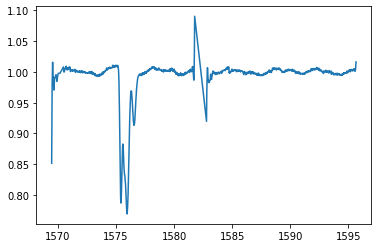

In [7]:
times, flux, _ = getData("lcs/tesslc_400799224")
fig = plt.subplot()
fig.plot(times, flux)
plt.show()

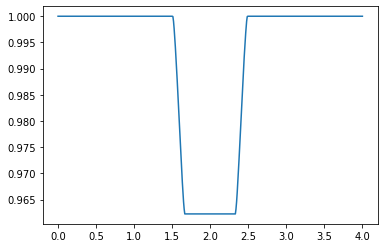

In [14]:
times = np.linspace(0,4,1000)
flux = transitSim(10,10,50,1,times,2,1)
fluxErr = 0.05*np.ones(1000)
fig = plt.subplot()
fig.plot(times, flux)
plt.show()

In [18]:
pos = [10,10,2,2,1] * np.ones([12,5]) + np.random.random([12,5]) - 0.5
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args = (times, flux, fluxErr))
    sampler.run_mcmc(pos,500, progress = True)

0.0455632209777832
0.027246713638305664
0.01688551902770996


  0%|                                                                                      | 0/500 [00:00<?, ?it/s]/home/jbromley/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|▏                                                                             | 1/500 [00:00<00:57,  8.71it/s]

0.05211758613586426
0.02487635612487793
0.015563726425170898
0.01909923553466797


  0%|▎                                                                             | 2/500 [00:00<00:54,  9.15it/s]

0.04198741912841797
0.016119718551635742
0.01918506622314453
0.023143291473388672
0.04116058349609375
0.018112897872924805
0.01823282241821289
0.019181013107299805
0.016866683959960938


  1%|▌                                                                             | 4/500 [00:00<00:45, 10.78it/s]

0.033707380294799805
0.011839866638183594
0.056571006774902344
0.009587287902832031


  1%|▉                                                                             | 6/500 [00:00<00:43, 11.34it/s]

0.022143125534057617
0.016396045684814453
0.017036914825439453
0.019153594970703125
0.019202470779418945
0.01391911506652832
0.01367044448852539
0.021284818649291992
0.11558890342712402
0.017179012298583984
0.03128480911254883


  2%|█▏                                                                            | 8/500 [00:00<00:56,  8.67it/s]

0.02071070671081543
0.026189088821411133
0.010898828506469727
0.0216829776763916
0.011568546295166016
0.021283864974975586
0.033004045486450195
0.015113592147827148
0.009403705596923828
0.006347179412841797
0.02055048942565918
0.012784481048583984


  2%|█▌                                                                           | 10/500 [00:01<00:56,  8.72it/s]

0.009662866592407227
0.010516166687011719
0.015011787414550781
0.045443058013916016
0.018505334854125977
0.012641668319702148
0.040387630462646484
0.029395580291748047
0.012027502059936523


  2%|█▋                                                                           | 11/500 [00:01<01:03,  7.69it/s]

0.024946212768554688
0.046121835708618164
0.008455991744995117
0.009349584579467773
0.12281441688537598


  2%|█▊                                                                           | 12/500 [00:01<01:10,  6.93it/s]

0.02482461929321289
0.009285688400268555
0.017846345901489258
0.012797117233276367
0.0033676624298095703
0.013709783554077148
0.008562803268432617
0.022208452224731445
0.011606454849243164
0.006687641143798828
0.04943561553955078
0.011839866638183594


  3%|██▍                                                                          | 16/500 [00:01<00:50,  9.65it/s]

0.030551671981811523
0.014379501342773438
0.0030927658081054688
0.019232511520385742
0.020306110382080078
0.018520116806030273
0.008202791213989258
0.011036396026611328
0.03016805648803711
0.008147716522216797
0.006154775619506836
0.033005714416503906
0.007012605667114258
0.0062448978424072266
0.004883289337158203


  4%|██▊                                                                          | 18/500 [00:01<00:45, 10.70it/s]

0.02043914794921875
0.011185169219970703
0.014463424682617188
0.02800273895263672
0.00984048843383789
0.01442861557006836
0.05772829055786133
0.0071527957916259766
0.004904031753540039
0.008838653564453125
0.015175342559814453


  4%|███                                                                          | 20/500 [00:02<01:15,  6.35it/s]

0.3909454345703125
0.02259349822998047
0.005031108856201172
0.009227752685546875
0.011344194412231445
0.016052722930908203
0.008249998092651367
0.011721134185791016
0.006265163421630859
0.018223047256469727
0.006727695465087891
0.005682468414306641
0.02142953872680664
0.028392553329467773
0.003124713897705078


  4%|███▏                                                                         | 21/500 [00:02<01:13,  6.51it/s]

0.030547380447387695
0.00577998161315918
0.0066030025482177734
0.018834352493286133
0.008056402206420898
0.01786351203918457
0.005383491516113281
0.018557310104370117
0.02163386344909668
0.011017560958862305
0.023387432098388672
0.018496990203857422
0.0054492950439453125
0.012508630752563477
0.01060175895690918


  5%|███▊                                                                         | 25/500 [00:03<00:58,  8.07it/s]

0.028829574584960938
0.005296945571899414
0.019002437591552734
0.010943889617919922
0.006940126419067383
0.006567716598510742
0.02344965934753418
0.008287668228149414
0.0056002140045166016
0.006660938262939453
0.00620579719543457
0.017878293991088867
0.011469364166259766
0.018082141876220703
0.006300687789916992
0.004936695098876953
0.018522977828979492
0.006822109222412109
0.00971531867980957
0.011398553848266602
0.006712675094604492
0.0056705474853515625
0.009209871292114258
0.006597280502319336
0.01938772201538086
0.018154144287109375
0.006302595138549805
0.008806467056274414
0.011281967163085938
0.011843681335449219
0.019291162490844727
0.007873296737670898
0.026075363159179688
0.006850719451904297
0.017992258071899414


  5%|████▏                                                                        | 27/500 [00:03<00:56,  8.36it/s]

0.00928497314453125
0.008247613906860352
0.006498575210571289
0.015277385711669922
0.01602959632873535
0.010868072509765625
0.005316019058227539
0.015270471572875977
0.0045850276947021484
0.006448984146118164
0.006337642669677734
0.010985612869262695
0.005924701690673828
0.005697965621948242
0.0065500736236572266
0.008018016815185547
0.005886077880859375


  6%|████▌                                                                        | 30/500 [00:03<00:59,  7.94it/s]

0.14832186698913574
0.018583059310913086
0.007042884826660156
0.011564970016479492
0.007966756820678711
0.004926443099975586
0.012934207916259766
0.010992765426635742
0.004867076873779297
0.011526107788085938
0.012568473815917969
0.007792472839355469
0.005380153656005859
0.0077593326568603516
0.007733345031738281
0.00917196273803711
0.011827707290649414
0.004700422286987305
0.004992961883544922
0.006701946258544922
0.008831501007080078


  6%|████▊                                                                        | 31/500 [00:03<01:08,  6.88it/s]

0.15219736099243164
0.008144140243530273
0.0038270950317382812
0.007915973663330078
0.005017518997192383
0.009033203125
0.015492916107177734
0.01080322265625


  6%|████▉                                                                        | 32/500 [00:04<01:23,  5.58it/s]

0.20577406883239746
0.012302398681640625
0.008818387985229492
0.0031626224517822266
0.00703883171081543
0.033629655838012695
0.011014223098754883
0.012398719787597656
0.011546611785888672
0.010147571563720703
0.005044698715209961
0.009589195251464844
0.004853725433349609
0.010680675506591797
0.009902000427246094
0.0041234493255615234
0.011246442794799805
0.0023844242095947266
0.010782480239868164
0.01145029067993164


  7%|█████▍                                                                       | 35/500 [00:04<01:06,  7.03it/s]

0.008915424346923828
0.017934083938598633
0.009828567504882812
0.007338762283325195
0.0068531036376953125
0.004842042922973633
0.01534724235534668
0.014357566833496094
0.004143476486206055
0.04715776443481445
0.00494837760925293
0.00906062126159668
0.005485057830810547
0.0070953369140625
0.0048830509185791016
0.019460439682006836
0.006963968276977539
0.002547025680541992


  8%|█████▊                                                                       | 38/500 [00:04<00:52,  8.80it/s]

0.050153255462646484
0.0042340755462646484
0.0073778629302978516
0.0055692195892333984
0.003583669662475586
0.0063838958740234375
0.020252466201782227
0.036020755767822266
0.01671123504638672
0.005613088607788086
0.006894588470458984
0.009112119674682617
0.013150453567504883
0.0072171688079833984
0.0034804344177246094
0.005323648452758789
0.013369560241699219
0.0037899017333984375
0.010132312774658203
0.01124119758605957

  8%|██████▏                                                                      | 40/500 [00:04<00:47,  9.65it/s]


0.002470254898071289
0.008148193359375
0.0298306941986084
0.009114503860473633
0.0043773651123046875
0.005275249481201172
0.007370471954345703
0.003719329833984375
0.012164831161499023
0.005089521408081055
0.002534151077270508
0.008631467819213867
0.01422262191772461
0.0056002140045166016
0.019719600677490234
0.006900310516357422
0.0057528018951416016
0.011120319366455078
0.005293607711791992


  8%|██████▎                                                                      | 41/500 [00:05<00:52,  8.74it/s]

0.08189654350280762
0.00396418571472168
0.005935192108154297
0.006093740463256836
0.014435291290283203
0.004648685455322266
0.0043451786041259766
0.007597446441650391
0.006987333297729492
0.012276887893676758


  8%|██████▍                                                                      | 42/500 [00:05<01:11,  6.42it/s]

0.2127828598022461
0.004931449890136719
0.004568576812744141
0.002494335174560547
0.004899263381958008
0.007215261459350586
0.0057942867279052734
0.004836082458496094
0.015053272247314453
0.00862264633178711
0.0024030208587646484
0.010051488876342773
0.010935068130493164
0.015243053436279297
0.005227804183959961
0.006082773208618164
0.005263328552246094
0.004469394683837891
0.010852813720703125
0.00407862663269043
0.0023267269134521484
0.004403591156005859
0.012293100357055664
0.022286653518676758
0.005024909973144531
0.008561372756958008


  9%|██████▊                                                                      | 44/500 [00:05<00:58,  7.83it/s]

0.009685754776000977
0.005029201507568359
0.004260063171386719
0.004576683044433594
0.0052127838134765625
0.005656242370605469
0.011193037033081055
0.0052340030670166016
0.008193492889404297
0.002469778060913086
0.005023002624511719
0.006962299346923828
0.007422208786010742
0.007574558258056641


  9%|███████▏                                                                     | 47/500 [00:06<01:22,  5.52it/s]

0.5288844108581543
0.005789518356323242
0.003934383392333984
0.005475759506225586
0.005037069320678711
0.007875680923461914
0.002924203872680664
0.010002851486206055
0.007477521896362305
0.005353450775146484
0.007632732391357422
0.0038421154022216797
0.03007030487060547
0.002355813980102539
0.005168437957763672
0.0056264400482177734
0.03380155563354492
0.004878044128417969
0.006462574005126953
0.003869295120239258
0.0030879974365234375
0.007509469985961914
0.011244773864746094
0.006307125091552734
0.0025229454040527344


 10%|███████▌                                                                     | 49/500 [00:06<01:04,  7.00it/s]

0.00796365737915039
0.0054395198822021484
0.008720874786376953
0.006525754928588867
0.007909059524536133
0.05438590049743652
0.004102468490600586
0.0038881301879882812
0.004573345184326172
0.00941610336303711
0.002524852752685547
0.006096601486206055
0.004972934722900391
0.005243539810180664
0.007373809814453125
0.004230976104736328
0.003769397735595703
0.004954814910888672
0.0035240650177001953
0.004040241241455078
0.009456396102905273
0.004529714584350586
0.008941173553466797
0.005754947662353516
0.002355337142944336
0.003909587860107422


 11%|████████▏                                                                    | 53/500 [00:06<00:42, 10.59it/s]

0.008637428283691406
0.007776975631713867
0.004102230072021484
0.004626274108886719
0.0024433135986328125
0.006670236587524414
0.008914470672607422
0.004112720489501953
0.003714323043823242
0.0055425167083740234
0.005868434906005859
0.007451057434082031
0.004416465759277344
0.0035059452056884766
0.0034317970275878906
0.006072998046875
0.00422215461730957
0.006794452667236328
0.0036001205444335938
0.004952907562255859
0.004590034484863281
0.005151510238647461
0.00852346420288086
0.004255771636962891
0.004464626312255859
0.004302501678466797
0.005334377288818359
0.0040514469146728516
0.0062525272369384766
0.002092599868774414
0.004175662994384766
0.00676417350769043
0.0045664310455322266
0.016739368438720703
0.002496480941772461
0.004624605178833008

 11%|████████▊                                                                    | 57/500 [00:06<00:33, 13.24it/s]


0.004228353500366211
0.011095046997070312
0.00465083122253418
0.0041425228118896484
0.004312276840209961
0.00417637825012207
0.003796100616455078
0.0036296844482421875
0.004567861557006836
0.002913951873779297
0.008078336715698242
0.012187957763671875
0.0042459964752197266
0.0037262439727783203
0.0055446624755859375
0.004059553146362305
0.0041658878326416016
0.0028536319732666016
0.006046772003173828
0.005580902099609375
0.00397038459777832
0.0041158199310302734
0.003532886505126953
0.0039615631103515625
0.0050699710845947266
0.0037229061126708984
0.005953311920166016
0.016698837280273438
0.004488706588745117
0.004667758941650391
0.008864879608154297
0.003895282745361328
0.003085613250732422
0.00417637825012207
0.0044918060302734375


 12%|█████████▏                                                                   | 60/500 [00:07<00:27, 15.83it/s]

0.007302045822143555
0.00467228889465332
0.007352590560913086
0.004068613052368164
0.002187490463256836
0.010838747024536133
0.004125118255615234
0.003826618194580078
0.004792690277099609
0.0043811798095703125
0.004040241241455078
0.009006977081298828
0.0033850669860839844
0.0038819313049316406
0.004515647888183594
0.003977537155151367
0.00539708137512207
0.0041086673736572266
0.003956317901611328
0.006267547607421875
0.004042625427246094
0.009421110153198242
0.0034379959106445312
0.004820823669433594
0.003664731979370117
0.005242109298706055
0.0030608177185058594
0.0049114227294921875
0.004462003707885742
0.012748479843139648
0.003863811492919922
0.0047397613525390625
0.004497528076171875
0.005345821380615234
0.0040760040283203125
0.005236625671386719
0.003980398178100586
0.0056247711181640625


 13%|██████████                                                                   | 65/500 [00:07<00:25, 17.38it/s]

0.0036554336547851562
0.004194736480712891
0.004586935043334961
0.0052378177642822266
0.019370555877685547
0.003796815872192383
0.0030434131622314453
0.004642486572265625
0.0037076473236083984
0.004212141036987305
0.005342245101928711
0.0037865638732910156
0.0059506893157958984
0.004766225814819336
0.0038976669311523438
0.00348663330078125
0.003251314163208008
0.003910541534423828
0.004279375076293945
0.0020971298217773438
0.006012916564941406
0.016101598739624023
0.004274606704711914
0.0058023929595947266
0.003629446029663086
0.006886959075927734
0.0037279129028320312


 13%|██████████▎                                                                  | 67/500 [00:07<00:29, 14.57it/s]

0.11551260948181152
0.0037293434143066406
0.002897977828979492
0.004224061965942383
0.005219221115112305
0.004926204681396484
0.006095409393310547
0.0035924911499023438
0.00402069091796875
0.003992795944213867
0.003594636917114258
0.0036084651947021484
0.004923582077026367
0.0046122074127197266
0.005190849304199219
0.004925251007080078
0.005226850509643555
0.004391193389892578
0.004259347915649414
0.0037741661071777344
0.0029222965240478516
0.0055425167083740234
0.003621816635131836
0.004950284957885742
0.0038137435913085938
0.0022284984588623047
0.011965513229370117
0.0034220218658447266
0.0035295486450195312
0.005232334136962891
0.0023565292358398438
0.003740072250366211
0.004067659378051758
0.003652334213256836
0.0023622512817382812
0.00438237190246582
0.002415895462036133
0.004572391510009766
0.004331111907958984
0.003912687301635742
0.008504867553710938
0.004198551177978516
0.004021167755126953
0.002387523651123047


 14%|███████████                                                                  | 72/500 [00:07<00:27, 15.73it/s]

0.0046923160552978516
0.004292726516723633
0.00496363639831543
0.004458427429199219
0.004275083541870117
0.004554033279418945
0.003172159194946289
0.004631519317626953
0.004138946533203125
0.003795623779296875
0.0035691261291503906
0.004271745681762695
0.002450227737426758
0.007647037506103516
0.002470731735229492
0.004029035568237305
0.0037240982055664062
0.002323627471923828
0.004796028137207031
0.04598116874694824
0.0024330615997314453
0.00449681282043457
0.0037343502044677734
0.0043065547943115234
0.0024204254150390625
0.003686666488647461
0.005145549774169922
0.0040035247802734375
0.0040018558502197266
0.004126310348510742
0.005456447601318359
0.0038962364196777344
0.012691497802734375
0.004278421401977539


 15%|███████████▊                                                                 | 77/500 [00:08<00:23, 18.07it/s]

0.0061380863189697266
0.004552125930786133
0.004399776458740234
0.0030062198638916016
0.003134489059448242
0.002526521682739258
0.003917694091796875
0.0036573410034179688
0.003603219985961914
0.0041959285736083984
0.004105806350708008
0.004517316818237305
0.0023241043090820312
0.004038095474243164
0.004508018493652344
0.0040585994720458984
0.002422332763671875
0.002148866653442383
0.004052400588989258
0.004225254058837891
0.005102396011352539
0.003899812698364258
0.004124641418457031
0.0032396316528320312
0.005268096923828125
0.005484342575073242
0.0036394596099853516
0.0038042068481445312
0.0024559497833251953
0.0033550262451171875
0.004802227020263672
0.006508588790893555
0.004446268081665039
0.002092599868774414
0.005917549133300781
0.0034368038177490234
0.004075527191162109
0.0041255950927734375
0.003247976303100586
0.0057446956634521484
0.00459599494934082
0.0035860538482666016
0.005232810974121094
0.003557443618774414
0.004118204116821289
0.006082773208618164
0.004506826400756836

 16%|████████████▏                                                                | 79/500 [00:08<00:34, 12.11it/s]

0.008382320404052734
0.009137153625488281
0.0038013458251953125
0.0031404495239257812
0.0063631534576416016
0.0031599998474121094
0.007875442504882812
0.0031435489654541016
0.004624128341674805
0.06163668632507324
0.007660865783691406
0.006702423095703125
0.003039121627807617
0.00751948356628418
0.004041910171508789
0.0033588409423828125
0.14040756225585938
0.0048236846923828125
1.7281277179718018
0.003970623016357422
0.033956050872802734
0.003873586654663086
0.004739522933959961
0.05636262893676758


 16%|████████████▍                                                                | 81/500 [00:10<02:50,  2.46it/s]

0.5169472694396973
0.0070040225982666016
0.003197193145751953
0.009062528610229492
0.006832599639892578
0.004041194915771484
0.006535530090332031
0.008922576904296875
0.022657155990600586
0.004437685012817383
0.003865957260131836
0.004363059997558594
0.10439419746398926
0.004263162612915039


 17%|████████████▊                                                                | 83/500 [00:11<02:17,  3.03it/s]

0.006410360336303711
0.0069272518157958984
0.004006862640380859
0.004054546356201172
0.003917694091796875
0.00449061393737793
0.006468772888183594
0.05791330337524414
0.004001140594482422
0.006206512451171875
0.22382330894470215
0.005067586898803711


 17%|████████████▉                                                                | 84/500 [00:13<04:06,  1.69it/s]

1.6474742889404297
0.004418134689331055
0.009931325912475586
0.00589442253112793
0.006746530532836914
0.0032444000244140625
0.006477832794189453
0.004206657409667969


 17%|█████████████▏                                                               | 86/500 [00:18<08:11,  1.19s/it]

5.1487627029418945
0.0068089962005615234
0.0041272640228271484
0.0036537647247314453
0.004300117492675781
0.007923126220703125
0.006379842758178711
0.030288219451904297
0.010704278945922852
0.004391670227050781
0.0064907073974609375
0.003917217254638672
0.004107952117919922
0.00823068618774414
0.002493143081665039
0.033452749252319336
0.0272064208984375
0.004099130630493164
0.00957942008972168
0.002403736114501953
0.00520014762878418


 17%|█████████████▍                                                               | 87/500 [00:18<06:30,  1.06it/s]

0.018508195877075195
0.0040400028228759766
0.010599851608276367
0.08179688453674316
0.006516933441162109
0.0030019283294677734
0.00821232795715332
0.004086017608642578
0.005286216735839844
0.006392002105712891


 18%|█████████████▌                                                               | 88/500 [00:19<05:28,  1.25it/s]

0.23090815544128418
0.00635838508605957
0.003324270248413086
0.019628047943115234
0.0057888031005859375
0.002329111099243164
0.05868673324584961
0.004459857940673828
0.007958173751831055
0.004230499267578125
0.007102251052856445


 18%|█████████████▋                                                               | 89/500 [00:25<15:42,  2.29s/it]

6.337679862976074
0.003888845443725586
0.08749747276306152
0.004355907440185547
0.008307933807373047
0.0041234493255615234
0.0038292407989501953
0.0038466453552246094
0.029151439666748047
0.012720108032226562
0.005147695541381836
0.008534431457519531
0.011734962463378906
0.0064334869384765625


 18%|█████████████▊                                                               | 90/500 [00:25<12:16,  1.80s/it]

0.3895988464355469
0.004198312759399414
0.004485130310058594
0.058173179626464844
0.011813163757324219
0.003761768341064453
0.0035228729248046875
0.003796815872192383


 18%|██████████████                                                               | 91/500 [00:32<20:55,  3.07s/it]

6.210450649261475
0.00639653205871582
0.00330352783203125
0.015211343765258789
0.0042188167572021484
0.005884885787963867
0.07770013809204102
0.002382516860961914


 18%|██████████████▏                                                              | 92/500 [00:32<15:46,  2.32s/it]

0.17601776123046875
0.004305124282836914
0.00998234748840332
0.08257770538330078
0.05105185508728027
0.03285408020019531
0.003153562545776367
0.010734081268310547
0.5773806571960449
0.03752422332763672
0.0065381526947021484
0.0043506622314453125
0.006025791168212891
0.022043228149414062
0.002430438995361328
0.0837249755859375


 19%|██████████████▎                                                              | 93/500 [00:33<12:50,  1.89s/it]

0.08894753456115723
0.004097700119018555
0.004354238510131836
0.016348600387573242
0.00751805305480957
0.006890773773193359
0.004076480865478516


 19%|██████████████▍                                                              | 94/500 [00:33<09:47,  1.45s/it]

0.24051403999328613
0.07538509368896484
0.003924846649169922
0.004866361618041992
0.004047870635986328
0.013415098190307617
0.08360910415649414
0.00903773307800293


 19%|██████████████▋                                                              | 95/500 [00:34<07:09,  1.06s/it]

0.005855083465576172
0.009145021438598633
0.004303932189941406
0.0042722225189208984
0.003920555114746094
0.004944801330566406


 19%|██████████████▊                                                              | 96/500 [00:36<08:58,  1.33s/it]

1.9367523193359375
0.002445697784423828
0.002978801727294922
0.00854182243347168
0.011039972305297852
0.005360841751098633
0.004668235778808594
0.005183696746826172


 19%|██████████████▉                                                              | 97/500 [00:37<08:46,  1.31s/it]

1.1340250968933105
0.003201723098754883
0.04470181465148926
0.004364967346191406
0.007897377014160156
0.010426759719848633
0.01688861846923828
0.0023102760314941406
0.012620687484741211
0.014867544174194336
0.00420069694519043
0.003032207489013672


 20%|███████████████                                                              | 98/500 [00:37<07:24,  1.11s/it]

0.4759700298309326
0.0048868656158447266
0.011225700378417969
0.07549691200256348
0.012926340103149414
0.013080835342407227
0.11063051223754883
0.04945039749145508
0.003966808319091797
0.020194053649902344
0.03460955619812012
0.0044896602630615234
0.007581233978271484
0.008236408233642578


 20%|███████████████▏                                                            | 100/500 [00:38<04:41,  1.42it/s]

0.30680227279663086
0.0048105716705322266
0.012687206268310547
0.028566598892211914
0.012691020965576172
0.05876612663269043
0.004484415054321289
0.004538774490356445
0.004410505294799805
0.0031478404998779297
0.016675472259521484
0.004360675811767578
0.036249637603759766
6.004664421081543
0.003607034683227539
0.1380782127380371
0.0035126209259033203


 20%|███████████████▎                                                            | 101/500 [00:45<16:22,  2.46s/it]

0.2547574043273926
0.10592007637023926
0.0043201446533203125
0.016697168350219727
0.0033881664276123047
0.1524050235748291
0.004978179931640625
0.004518747329711914
0.07316803932189941
0.0043714046478271484
0.00237274169921875
0.00935053825378418


 20%|███████████████▌                                                            | 102/500 [00:48<16:56,  2.55s/it]

2.4227449893951416
0.07885074615478516
0.0065081119537353516
0.003162860870361328
0.0796043872833252


 21%|███████████████▋                                                            | 103/500 [00:48<12:32,  1.90s/it]

0.19970989227294922
0.004034519195556641
0.019982576370239258
0.011007070541381836
0.0330960750579834
0.2091994285583496
6.151458978652954
0.003908872604370117


 21%|███████████████▊                                                            | 104/500 [00:55<22:18,  3.38s/it]

0.2852306365966797
0.007276296615600586
0.0047152042388916016
0.02427053451538086
0.044466257095336914
0.05092763900756836
0.0024635791778564453
0.05433225631713867
0.023693561553955078
0.0025119781494140625
0.0036497116088867188
0.09508323669433594
0.004294872283935547
0.04516887664794922
0.0035240650177001953
0.02826213836669922


 21%|███████████████▉                                                            | 105/500 [00:55<16:02,  2.44s/it]

0.020822763442993164
0.027424335479736328
0.11527466773986816
0.0034253597259521484
0.0032906532287597656


 21%|████████████████                                                            | 106/500 [00:55<11:53,  1.81s/it]

0.09153962135314941
0.004652976989746094
0.048685550689697266
0.019180774688720703
0.028631210327148438
0.0039708614349365234
0.035147666931152344
0.06378722190856934
0.05776381492614746
0.006722211837768555
0.012178182601928711
0.10861444473266602


 21%|████████████████▎                                                           | 107/500 [01:02<20:52,  3.19s/it]

6.107971906661987
0.03534507751464844
0.04155707359313965
0.09903287887573242
0.15384888648986816
0.003991127014160156
0.004212379455566406
0.004453182220458984
0.11724710464477539


 22%|████████████████▍                                                           | 108/500 [01:02<15:46,  2.41s/it]

0.11760640144348145
0.028742313385009766
0.03532910346984863
0.05610203742980957


 22%|████████████████▌                                                           | 109/500 [01:03<11:35,  1.78s/it]

0.09037637710571289
0.05069589614868164
0.0037376880645751953
0.0040283203125
0.006024360656738281
0.009480476379394531
0.03206157684326172
0.004059553146362305
0.05191469192504883
0.04923272132873535
0.12575531005859375
0.004738807678222656


 22%|████████████████▋                                                           | 110/500 [01:03<09:09,  1.41s/it]

0.15498018264770508
0.011324644088745117
0.0045108795166015625
0.13482880592346191
0.027586936950683594
0.08662652969360352
0.003200054168701172
0.07213163375854492
0.031569719314575195
0.004292964935302734
0.01797008514404297


 22%|████████████████▊                                                           | 111/500 [01:04<07:08,  1.10s/it]

0.08654022216796875
0.004777669906616211
0.04411602020263672
0.0761864185333252
0.10616946220397949
0.004312992095947266
0.1493234634399414
0.09071874618530273
0.00419926643371582
0.030447959899902344
0.02592754364013672


 22%|█████████████████                                                           | 112/500 [01:04<06:39,  1.03s/it]

0.23146748542785645
0.1324458122253418
0.05034279823303223
0.004620552062988281
0.02754044532775879
0.08600163459777832
0.08582162857055664
0.0035009384155273438
0.0031890869140625
0.13526344299316406
0.11605048179626465


 23%|█████████████████▏                                                          | 113/500 [01:05<05:49,  1.11it/s]

0.08791160583496094
0.0481114387512207
0.054888010025024414
0.002475261688232422
0.003286600112915039
0.1769568920135498
0.0871584415435791
0.0075418949127197266
0.26900219917297363
0.06722664833068848
0.0656440258026123


 23%|█████████████████▎                                                          | 114/500 [01:06<05:44,  1.12it/s]

0.08056426048278809
0.22676897048950195
0.004042148590087891
0.09961986541748047
0.08625388145446777
0.01696467399597168
0.0853278636932373
0.036969661712646484
0.06778073310852051


 23%|█████████████████▍                                                          | 115/500 [01:07<05:29,  1.17it/s]

0.14482426643371582
0.005191802978515625
0.06253361701965332
0.04508638381958008
0.004072904586791992
0.003046751022338867
0.14815235137939453
0.0025022029876708984
0.07549357414245605


 23%|█████████████████▋                                                          | 116/500 [01:07<05:05,  1.26it/s]

0.16747307777404785
0.1346287727355957
0.05413818359375
0.019069671630859375
0.010656356811523438
0.1251683235168457
0.11505770683288574
0.19757676124572754
0.07046031951904297
0.0847630500793457
0.004506349563598633
0.002361297607421875


 23%|█████████████████▊                                                          | 117/500 [01:08<05:07,  1.24it/s]

0.13150906562805176
0.004347801208496094
0.1558699607849121


 24%|█████████████████▉                                                          | 118/500 [01:08<04:17,  1.48it/s]

0.07814884185791016
0.0329434871673584
0.06203484535217285
0.02616095542907715
0.0039157867431640625
0.0025534629821777344
0.0035142898559570312
0.0033788681030273438
0.08828401565551758
0.059249162673950195
0.005423069000244141
0.0024263858795166016
0.1074821949005127
0.0679616928100586
0.016923904418945312
0.05447840690612793
0.11146259307861328


 24%|██████████████████                                                          | 119/500 [01:09<04:16,  1.48it/s]

0.1487410068511963
0.10431814193725586
0.048882484436035156
0.28919172286987305
0.06361770629882812
0.0031881332397460938
0.004627227783203125
0.062297821044921875


 24%|██████████████████▏                                                         | 120/500 [01:10<04:35,  1.38it/s]

0.11688804626464844
0.006744861602783203
0.13332796096801758
0.0456843376159668
0.03506207466125488
0.06890654563903809
0.08014369010925293
0.14643335342407227
0.003831624984741211
0.08666276931762695
0.0033295154571533203
0.014141321182250977


 24%|██████████████████▍                                                         | 121/500 [01:11<04:21,  1.45it/s]

0.12463736534118652
0.15244817733764648
0.06348490715026855
0.09896206855773926
0.002471923828125
0.0031735897064208984
0.12191343307495117
0.04725003242492676
0.006368160247802734
0.011518478393554688
0.134904146194458

 24%|██████████████████▌                                                         | 122/500 [01:11<04:16,  1.47it/s]


0.12245297431945801
0.12162923812866211
0.024878263473510742
0.15723228454589844


 25%|██████████████████▋                                                         | 123/500 [01:12<04:41,  1.34it/s]

0.32781004905700684
0.004012346267700195
0.053919315338134766
0.08443546295166016
0.0036721229553222656
0.0032796859741210938
0.1397719383239746
0.06350970268249512
0.09658932685852051
0.13968110084533691
0.048160552978515625


 25%|██████████████████▊                                                         | 124/500 [01:13<04:53,  1.28it/s]

0.23881959915161133
0.1218106746673584
0.13879776000976562
0.081207275390625
0.006658792495727539
0.10783147811889648
0.003078937530517578
0.1663374900817871


 25%|███████████████████                                                         | 125/500 [01:14<04:28,  1.39it/s]

0.05357170104980469
0.004551410675048828
0.10057854652404785
0.008549213409423828
0.14031243324279785
0.12616443634033203
0.13896656036376953
0.17464685440063477
0.039816856384277344


 25%|███████████████████▏                                                        | 126/500 [01:15<04:55,  1.26it/s]

0.22375774383544922
0.00409388542175293
0.003718852996826172
0.06529760360717773
0.08511900901794434
0.10999202728271484
0.5517821311950684
0.13629937171936035


 25%|███████████████████▎                                                        | 127/500 [01:16<05:47,  1.07it/s]

0.10320234298706055
0.0086212158203125
0.0032570362091064453
0.18610000610351562
0.00385284423828125
0.2155590057373047
0.09051680564880371
0.0789635181427002
0.004386425018310547
0.004374265670776367


 26%|███████████████████▍                                                        | 128/500 [01:16<04:54,  1.26it/s]

0.06351685523986816
0.0042612552642822266
0.11201858520507812
0.059710025787353516
0.11350297927856445
0.16413497924804688


 26%|███████████████████▌                                                        | 129/500 [01:17<04:28,  1.38it/s]

0.0626225471496582
0.03847694396972656
0.007047414779663086
0.0033617019653320312
0.03868508338928223
0.11684107780456543
1.0112059116363525
0.15897059440612793


 26%|███████████████████▊                                                        | 130/500 [01:19<06:13,  1.01s/it]

0.169450044631958
0.06826281547546387
0.006025552749633789
0.09888339042663574
0.0040094852447509766
0.18339753150939941
0.26973533630371094
0.10743975639343262
0.11654043197631836
0.20479154586791992
0.08202409744262695
0.00409698486328125


 26%|███████████████████▉                                                        | 131/500 [01:20<06:28,  1.05s/it]

0.17400622367858887
0.05887341499328613
0.10158014297485352
0.006633758544921875
0.004014730453491211
0.1881847381591797


 26%|████████████████████                                                        | 132/500 [01:21<06:14,  1.02s/it]

0.3897383213043213
0.17869019508361816
0.004324674606323242
0.1916975975036621
0.06596636772155762
0.008357524871826172
0.12933111190795898


 27%|████████████████████▏                                                       | 133/500 [01:22<06:12,  1.02s/it]

0.4644453525543213
0.0030100345611572266
0.1358504295349121
0.003294706344604492
0.003999471664428711
0.06838798522949219
0.004962444305419922
0.23737263679504395
0.0036902427673339844
0.09589123725891113


 27%|████████████████████▎                                                       | 134/500 [01:22<05:36,  1.09it/s]

0.124542236328125
0.0037581920623779297
0.14514589309692383
0.046579837799072266
0.12654900550842285
0.0030562877655029297
0.20644092559814453
0.005009651184082031
0.4264237880706787
0.005602598190307617
0.1761307716369629


 27%|████████████████████▌                                                       | 135/500 [01:23<05:56,  1.02it/s]

0.10574126243591309
0.15267539024353027
1.2447147369384766
0.08107876777648926
0.13062596321105957
0.0023779869079589844
0.100830078125
0.003332853317260742


 27%|████████████████████▋                                                       | 136/500 [01:25<07:47,  1.28s/it]

0.10254454612731934
0.004260063171386719
0.1733262538909912
0.0036835670471191406
0.29471445083618164
0.08507227897644043
0.11938691139221191
0.004504680633544922
0.14809393882751465


 27%|████████████████████▊                                                       | 137/500 [01:26<07:09,  1.18s/it]

0.12114977836608887
0.06845974922180176
0.006386280059814453
0.08893728256225586
0.003692626953125
0.13214802742004395
0.3115983009338379
0.007664680480957031
0.0023686885833740234
0.09766769409179688
0.1640915870666504
0.08132767677307129
0.004384040832519531
0.12753772735595703
0.15614843368530273


 28%|████████████████████▉                                                       | 138/500 [01:28<07:15,  1.20s/it]

0.1602015495300293
0.0037720203399658203
0.11876058578491211
0.16273903846740723
0.4345672130584717
0.10792279243469238
0.06882214546203613


 28%|█████████████████████▏                                                      | 139/500 [01:29<07:11,  1.20s/it]

0.10452771186828613
0.00559544563293457
0.0024971961975097656
0.16194629669189453
0.0031766891479492188
0.47284817695617676
0.18636512756347656
0.004541873931884766
0.11772418022155762
0.12227392196655273
0.005616664886474609


 28%|█████████████████████▎                                                      | 140/500 [01:30<06:54,  1.15s/it]

0.13213753700256348
0.01803302764892578
0.10375285148620605
0.004512786865234375
0.15111875534057617
0.14686131477355957
0.004128694534301758
0.13119888305664062
0.21001172065734863
0.09309625625610352


 28%|█████████████████████▍                                                      | 141/500 [01:31<06:41,  1.12s/it]

0.16042351722717285
0.012810230255126953
0.004540205001831055
0.08531332015991211
0.0023195743560791016
0.2084038257598877
0.1816093921661377
0.005249500274658203
0.0033614635467529297


 28%|█████████████████████▌                                                      | 142/500 [01:32<06:15,  1.05s/it]

0.2518637180328369
0.0071446895599365234
0.1287212371826172
0.004381895065307617
0.10124373435974121
0.17919206619262695
0.0023374557495117188
0.2056410312652588
6.014386415481567
0.11680865287780762


 29%|█████████████████████▋                                                      | 143/500 [01:39<17:29,  2.94s/it]

0.6141645908355713
0.004267215728759766
0.004448890686035156
0.007879257202148438
0.09421348571777344
0.002407550811767578
0.10968875885009766
0.11465215682983398
0.007917642593383789
0.004445075988769531
0.08428192138671875
0.04979586601257324
0.13490605354309082
0.004229545593261719


 29%|█████████████████████▉                                                      | 144/500 [01:40<13:41,  2.31s/it]

0.13028454780578613
0.04117846488952637
0.13866901397705078
0.007853984832763672
0.1048421859741211
0.12195634841918945
0.15454339981079102
0.004439592361450195
0.13711786270141602
0.003286600112915039
0.011841058731079102
0.0032656192779541016


 29%|██████████████████████                                                      | 145/500 [01:41<10:43,  1.81s/it]

0.10530233383178711
0.006676673889160156
0.14148616790771484
0.11242485046386719
0.006284236907958984
0.0727841854095459
0.003889799118041992
0.004160881042480469
0.002324342727661133
0.19055509567260742


 29%|██████████████████████▏                                                     | 146/500 [01:41<08:53,  1.51s/it]

0.24770355224609375
0.1056981086730957
0.1047811508178711
0.004267454147338867
0.014878988265991211
0.005228281021118164
0.11653947830200195


 29%|██████████████████████▎                                                     | 147/500 [01:42<07:13,  1.23s/it]

0.13649439811706543
0.08226847648620605
0.020774126052856445
0.11792635917663574
0.003066539764404297
0.15188264846801758
0.1629939079284668
0.003930091857910156
0.1488490104675293
0.00558161735534668
0.010022640228271484


 30%|██████████████████████▍                                                     | 148/500 [01:43<06:20,  1.08s/it]

0.10277080535888672
0.006378650665283203
0.047837257385253906
0.009105205535888672
0.14501452445983887
0.018291711807250977
0.09960603713989258


 30%|██████████████████████▋                                                     | 149/500 [01:43<05:31,  1.06it/s]

0.15068316459655762
0.11767363548278809
0.021453380584716797
0.0022804737091064453
0.1292858123779297
0.1382122039794922
0.004148244857788086
0.015433788299560547
0.004036426544189453
0.11912894248962402
0.11276364326477051
0.004651784896850586


 30%|██████████████████████▊                                                     | 150/500 [01:44<05:13,  1.12it/s]

0.15092110633850098
0.09611296653747559
0.004048824310302734
0.09926700592041016
0.18386602401733398


 30%|██████████████████████▉                                                     | 151/500 [01:45<04:17,  1.36it/s]

0.04355192184448242
0.004124879837036133
0.025969982147216797
0.003796100616455078
0.009186744689941406
0.1243746280670166
0.16029953956604004
0.0038051605224609375
0.18683099746704102
0.0037009716033935547


 30%|███████████████████████                                                     | 152/500 [01:45<04:01,  1.44it/s]

0.0993497371673584
0.0035305023193359375
0.12279343605041504
0.37510108947753906
0.12782001495361328
0.004264116287231445
0.01694488525390625
0.16359639167785645
0.007734775543212891
0.11101603507995605


 31%|███████████████████████▎                                                    | 153/500 [01:46<04:53,  1.18it/s]

0.14969372749328613
0.0022802352905273438
0.10614800453186035
0.0185239315032959
0.09268736839294434
0.22341346740722656
0.18151021003723145
0.13195228576660156
0.18514227867126465


 31%|███████████████████████▍                                                    | 154/500 [01:47<05:06,  1.13it/s]

0.11235451698303223
0.026586532592773438
0.005227327346801758
0.020030498504638672
0.0037369728088378906
0.16465020179748535
0.16409564018249512
0.0927128791809082
0.138838529586792


 31%|███████████████████████▌                                                    | 155/500 [01:48<05:03,  1.14it/s]

0.16427350044250488
0.06114029884338379
0.04400825500488281
0.0022695064544677734
0.11009359359741211
6.026217460632324
0.09794163703918457
0.0031948089599609375
0.010703563690185547
0.12282061576843262
0.0038514137268066406
0.038326263427734375


 31%|███████████████████████▋                                                    | 156/500 [01:55<14:56,  2.61s/it]

0.21541380882263184
0.015232563018798828
0.11467337608337402
0.1129608154296875
0.002458810806274414
0.18390321731567383
0.1249094009399414
0.04923844337463379


 31%|███████████████████████▊                                                    | 157/500 [01:56<11:51,  2.07s/it]

0.22426295280456543
0.068603515625
0.03995537757873535
0.14119887351989746
0.8061723709106445
0.011790275573730469
0.16337847709655762


 32%|████████████████████████                                                    | 158/500 [01:57<10:51,  1.91s/it]

0.13214325904846191
0.0049343109130859375
0.03284192085266113
0.10523247718811035
0.014955759048461914
0.185347318649292
0.13875198364257812
0.003472566604614258
0.003415822982788086
0.10654473304748535
0.48397135734558105
0.003865480422973633
0.10779404640197754
0.002508878707885742


 32%|████████████████████████▏                                                   | 159/500 [01:58<09:39,  1.70s/it]

0.15732789039611816
0.1465153694152832
0.14314937591552734
0.13742756843566895
5.525027513504028
0.013448715209960938
0.16218352317810059
0.1231224536895752
0.03848671913146973


 32%|████████████████████████▎                                                   | 160/500 [02:05<17:43,  3.13s/it]

0.16808772087097168
0.01682448387145996
0.16498517990112305
0.09416341781616211
0.039998769760131836
0.0034537315368652344
0.177293062210083
0.11782622337341309


 32%|████████████████████████▍                                                   | 161/500 [02:06<13:46,  2.44s/it]

0.12069272994995117
0.0037724971771240234
0.008311986923217773
0.07335090637207031
0.15367722511291504
0.10598397254943848
0.10435032844543457
0.0039031505584716797
0.08753180503845215
0.17357540130615234
0.13324999809265137
0.015465736389160156


 32%|████████████████████████▌                                                   | 162/500 [02:07<11:38,  2.07s/it]

0.23642730712890625
0.17674541473388672
0.19786596298217773
0.09695792198181152
0.12192988395690918
0.0807180404663086
0.006978750228881836
0.003847837448120117
0.03867197036743164


 33%|████████████████████████▊                                                   | 163/500 [02:08<09:19,  1.66s/it]

0.16092491149902344
0.006506443023681641
0.14871644973754883
0.12268543243408203
0.03211259841918945
0.15042805671691895
0.10596632957458496
0.08712935447692871
0.11093020439147949
0.006168842315673828
0.04894447326660156
0.0024526119232177734


 33%|████████████████████████▉                                                   | 164/500 [02:09<08:31,  1.52s/it]

0.3746304512023926
0.007172107696533203
0.17921876907348633
0.003362894058227539
0.02277660369873047
0.0026276111602783203
0.12180066108703613
0.00718235969543457
0.004207611083984375


 33%|█████████████████████████                                                   | 165/500 [02:09<06:55,  1.24s/it]

0.15746355056762695
0.06954336166381836
0.1698448657989502
0.06913065910339355
0.1058187484741211
0.008161783218383789


 33%|█████████████████████████▏                                                  | 166/500 [02:10<06:03,  1.09s/it]

0.2456369400024414
0.1015326976776123
0.003822803497314453
0.027347803115844727
0.00904393196105957
0.10370945930480957
0.12240362167358398
0.054451942443847656
0.0037317276000976562
0.12608003616333008
0.0034978389739990234
0.12503266334533691


 33%|█████████████████████████▍                                                  | 167/500 [02:11<05:44,  1.03s/it]

0.2394237518310547
0.1084742546081543
0.25977110862731934
5.687984466552734
0.003707408905029297
0.12053060531616211
0.1770458221435547
0.09659051895141602
0.01163792610168457
0.1740436553955078
0.13030743598937988


 34%|█████████████████████████▌                                                  | 168/500 [02:18<15:22,  2.78s/it]

0.07366418838500977
0.10521483421325684
0.011554479598999023
0.1772909164428711
0.0037145614624023438
0.16697192192077637
0.12109923362731934
0.09031438827514648
0.0023577213287353516


 34%|█████████████████████████▋                                                  | 169/500 [02:19<11:53,  2.15s/it]

0.12058234214782715
0.0022020339965820312
0.0039441585540771484
0.22702264785766602
0.10301065444946289
0.0934138298034668
0.019852876663208008
0.30654382705688477
0.10214114189147949


 34%|█████████████████████████▊                                                  | 170/500 [02:20<09:57,  1.81s/it]

0.14828968048095703
0.024363279342651367
0.0032019615173339844
0.10930538177490234
0.2797112464904785
0.09859895706176758
0.0036439895629882812


 34%|█████████████████████████▉                                                  | 171/500 [02:20<08:05,  1.47s/it]

0.16112470626831055
0.004511356353759766
0.01610589027404785
0.1815943717956543
0.09310770034790039
0.0034110546112060547
0.11958742141723633


 34%|██████████████████████████▏                                                 | 172/500 [02:21<06:58,  1.28s/it]

0.21666383743286133
0.12796616554260254
0.0425267219543457
0.003497600555419922
0.03393411636352539
0.34369349479675293
0.1408555507659912
0.004630327224731445
0.04768562316894531
0.00484776496887207


 35%|██████████████████████████▎                                                 | 173/500 [02:22<06:14,  1.14s/it]

0.1540699005126953
0.1038358211517334
0.050437211990356445
0.23113012313842773
0.09349703788757324
0.002488374710083008
0.11654329299926758
0.06133723258972168
0.11668157577514648
0.08655810356140137
0.16866779327392578


 35%|██████████████████████████▍                                                 | 174/500 [02:23<06:04,  1.12s/it]

0.11775350570678711
0.20608925819396973
0.004155635833740234
0.1422593593597412
0.10179615020751953
0.08646607398986816
0.00433802604675293


 35%|██████████████████████████▌                                                 | 175/500 [02:24<05:28,  1.01s/it]

0.1250135898590088
0.08163571357727051
0.0039865970611572266
0.013329505920410156
0.13016891479492188
0.1832127571105957
0.08776593208312988
0.16646742820739746
0.07683992385864258
0.0028324127197265625
0.13892316818237305


 35%|██████████████████████████▊                                                 | 176/500 [02:25<05:31,  1.02s/it]

0.13385248184204102
0.11355948448181152
0.3976249694824219
0.3657362461090088
0.003292083740234375
0.2803483009338379
0.08281469345092773
0.07716846466064453


 35%|██████████████████████████▉                                                 | 177/500 [02:26<06:22,  1.18s/it]

0.2157456874847412
0.13189482688903809
0.1846790313720703
0.004262208938598633
0.12382125854492188
0.018477916717529297
0.08071470260620117
0.13144564628601074
0.06766414642333984
0.09460949897766113
0.0854339599609375
0.004652261734008789


 36%|███████████████████████████                                                 | 178/500 [02:27<06:02,  1.13s/it]

0.18440842628479004
0.004433631896972656
0.04528355598449707
0.19507241249084473
0.007889270782470703
0.21524286270141602
0.14382410049438477
0.003281116485595703


 36%|███████████████████████████▏                                                | 179/500 [02:28<05:33,  1.04s/it]

0.11882972717285156
0.003027200698852539
0.09107303619384766
0.12474536895751953
0.003966093063354492
0.10632181167602539
0.06686854362487793
0.133575439453125
0.10118961334228516
0.014939546585083008
0.1631009578704834
0.09802508354187012


 36%|███████████████████████████▎                                                | 180/500 [02:29<05:26,  1.02s/it]

0.1653275489807129
0.0894010066986084
0.08212447166442871
0.0033159255981445312
0.13176727294921875
0.13034963607788086
0.006323575973510742
0.004490852355957031
0.1297614574432373
0.11798238754272461
0.055034637451171875


 36%|███████████████████████████▌                                                | 181/500 [02:30<05:23,  1.02s/it]

0.24349522590637207
0.07851457595825195
0.002653837203979492
0.002299785614013672
0.13729047775268555
0.06963181495666504
0.004148721694946289
0.16272377967834473
0.1238241195678711


 36%|███████████████████████████▋                                                | 182/500 [02:31<05:05,  1.04it/s]

0.13739299774169922
0.10408449172973633
0.09218001365661621
0.12900567054748535
0.1003117561340332
0.12978625297546387
0.005353212356567383
0.22545981407165527
0.13100934028625488
0.004073381423950195


 37%|███████████████████████████▊                                                | 183/500 [02:32<05:13,  1.01it/s]

0.13243389129638672
0.1003415584564209
0.3540782928466797
0.13172197341918945
0.13222980499267578
0.31170129776000977
6.20799994468689
0.10198187828063965
0.07339859008789062


 37%|███████████████████████████▉                                                | 184/500 [02:40<15:36,  2.96s/it]

0.13435983657836914
0.11016583442687988
0.0041751861572265625
0.003792285919189453
0.15539312362670898
0.009053945541381836
0.07045912742614746
0.15045690536499023
0.13240385055541992
0.07626652717590332
0.12554311752319336
0.009551286697387695


 37%|████████████████████████████                                                | 185/500 [02:41<12:25,  2.37s/it]

0.12139773368835449
0.11356472969055176
0.0024678707122802734
0.0042345523834228516
0.2513279914855957
0.11288642883300781
0.20619750022888184
0.1219472885131836


 37%|████████████████████████████▎                                               | 186/500 [02:42<10:11,  1.95s/it]

0.10430550575256348
0.1238410472869873
0.003055572509765625
0.03804445266723633
0.09785652160644531
0.008557319641113281
0.11969590187072754
0.1223456859588623
0.0031342506408691406
0.058846473693847656
0.15486621856689453
0.1262674331665039
0.13350200653076172
0.14199304580688477


 37%|████████████████████████████▍                                               | 187/500 [02:45<11:49,  2.27s/it]

2.0347673892974854
0.10111331939697266
0.15894317626953125
0.107025146484375
0.004942178726196289
0.1343691349029541
0.0026569366455078125
0.12040424346923828
0.12197613716125488
0.1829524040222168


 38%|████████████████████████████▌                                               | 188/500 [02:46<10:07,  1.95s/it]

0.14469265937805176
0.11705708503723145
0.09817194938659668
0.11155343055725098
0.1243135929107666
0.055504798889160156
0.10972023010253906
0.1193854808807373
0.005699872970581055
0.10925865173339844
0.003928661346435547


 38%|████████████████████████████▋                                               | 189/500 [02:47<08:28,  1.64s/it]

0.1657090187072754
0.09964776039123535
0.0024690628051757812
0.15759611129760742
0.13485980033874512
0.10431146621704102
0.14372849464416504
0.11765003204345703
0.11002349853515625
0.01708984375


 38%|████████████████████████████▉                                               | 190/500 [02:48<07:30,  1.45s/it]

0.1312556266784668
0.1108555793762207
0.15557599067687988
0.11082720756530762
0.0170440673828125
0.0023665428161621094
0.09656977653503418
0.1186983585357666


 38%|█████████████████████████████                                               | 191/500 [02:48<06:23,  1.24s/it]

0.12560582160949707
0.035208940505981445
0.14591598510742188
0.1468486785888672
0.0038661956787109375
0.14504289627075195
0.14536213874816895
0.0973656177520752
0.1304931640625
0.12519192695617676
0.01089930534362793


 38%|█████████████████████████████▏                                              | 192/500 [02:50<06:10,  1.20s/it]

0.12355375289916992
0.08220171928405762
0.01691579818725586
0.12126898765563965
0.1501777172088623
0.12237143516540527
0.1631028652191162
0.10713028907775879
0.11830830574035645


 39%|█████████████████████████████▎                                              | 193/500 [02:51<06:04,  1.19s/it]

0.12776446342468262
0.13508844375610352
0.11983633041381836
0.12056684494018555
0.12560796737670898
0.11609816551208496
0.0037207603454589844
0.12969398498535156
0.08254432678222656
0.13343095779418945
0.12484383583068848
0.004154682159423828


 39%|█████████████████████████████▍                                              | 194/500 [02:52<06:10,  1.21s/it]

0.18251466751098633
0.11672043800354004
0.0668482780456543
0.09438657760620117
0.12277746200561523
0.1316230297088623
0.1210331916809082
0.14109516143798828
0.0155487060546875
0.12218236923217773


 39%|█████████████████████████████▋                                              | 195/500 [02:53<05:44,  1.13s/it]

0.1181020736694336
0.009181737899780273
0.0032126903533935547
0.14526963233947754
0.10745096206665039
0.10068893432617188
0.14760303497314453
0.10515379905700684


 39%|█████████████████████████████▊                                              | 196/500 [02:54<05:21,  1.06s/it]

0.13846516609191895
0.12132596969604492
0.18862676620483398
0.16684317588806152
0.1518545150756836
0.12176895141601562


 39%|█████████████████████████████▉                                              | 197/500 [02:55<04:53,  1.03it/s]

0.12065553665161133
0.009422779083251953
0.11516380310058594
0.11132168769836426
0.1222081184387207
0.12841081619262695
0.2567429542541504
0.1028294563293457
0.0892171859741211
0.012080907821655273
0.12210464477539062
0.003585338592529297


 40%|██████████████████████████████                                              | 198/500 [02:56<05:16,  1.05s/it]

0.16367864608764648
0.08912205696105957
0.14847302436828613
0.0979454517364502
0.006661176681518555
0.1016225814819336
0.12149930000305176
0.1251828670501709
0.13081932067871094
0.0036001205444335938
0.19200515747070312


 40%|██████████████████████████████▏                                             | 199/500 [03:03<14:19,  2.86s/it]

6.052003383636475
0.3215463161468506
0.14224791526794434
0.06278014183044434
0.044385671615600586
0.18040776252746582
0.12198472023010254
0.020003080368041992
0.10129737854003906
0.12956953048706055
0.0023174285888671875


 40%|██████████████████████████████▍                                             | 200/500 [03:04<11:56,  2.39s/it]

0.15748333930969238
0.16264867782592773
0.013973474502563477
0.003724813461303711
0.1286458969116211
0.09980916976928711
0.12331652641296387
0.09402894973754883


 40%|██████████████████████████████▌                                             | 201/500 [03:05<09:40,  1.94s/it]

0.16973018646240234
0.10005760192871094
0.3770153522491455
0.1739177703857422
0.07133960723876953
0.1239619255065918
0.24890851974487305
0.10493946075439453
0.013863801956176758
0.002333402633666992


 40%|██████████████████████████████▋                                             | 202/500 [03:06<08:43,  1.76s/it]

0.2083606719970703
0.015135049819946289
0.1322462558746338
0.12003660202026367
0.3872718811035156
0.07175779342651367
0.08443570137023926


 41%|██████████████████████████████▊                                             | 203/500 [03:07<07:22,  1.49s/it]

0.04918241500854492
0.11322283744812012
0.13234853744506836
0.1028749942779541
0.003282785415649414
0.15676355361938477
0.08998394012451172
0.0770730972290039
0.15502405166625977
0.09613561630249023
0.041794538497924805


 41%|███████████████████████████████                                             | 204/500 [03:09<07:03,  1.43s/it]

0.14448046684265137
0.1737356185913086
0.11328482627868652
0.053991079330444336
0.0032851696014404297
0.1499011516571045
0.1025688648223877


 41%|███████████████████████████████▏                                            | 205/500 [03:09<05:55,  1.21s/it]

0.17058706283569336
0.0024261474609375
0.07879424095153809
0.1591036319732666
0.1160135269165039
0.20070981979370117
0.16800427436828613
0.08924412727355957
0.10781288146972656
0.1570749282836914
0.11135101318359375
0.06457281112670898


 41%|███████████████████████████████▎                                            | 206/500 [03:11<06:15,  1.28s/it]

0.14176487922668457
0.12443876266479492
0.15837693214416504
0.0865929126739502
0.13225579261779785
0.15571928024291992
0.13624072074890137
0.09978485107421875


 41%|███████████████████████████████▍                                            | 207/500 [03:12<05:54,  1.21s/it]

0.15960335731506348
0.11110901832580566
0.004281759262084961
0.08171582221984863
0.15024304389953613
0.07407283782958984
0.1133873462677002
0.16006898880004883
0.23559117317199707
0.1298818588256836
0.13346314430236816
0.13361740112304688


 42%|███████████████████████████████▌                                            | 208/500 [03:13<06:03,  1.24s/it]

0.10399341583251953
0.07154107093811035
0.11399459838867188
0.1418318748474121
0.17661237716674805
0.1837763786315918
0.12816810607910156
0.13345980644226074
0.08568477630615234
0.003519773483276367


 42%|███████████████████████████████▊                                            | 209/500 [03:14<05:56,  1.23s/it]

0.14049410820007324
0.13475584983825684
0.1697835922241211
0.11541223526000977
0.15906739234924316
0.11658024787902832
0.08111834526062012


 42%|███████████████████████████████▉                                            | 210/500 [03:15<05:31,  1.14s/it]

0.005132913589477539
0.16299057006835938
0.1435079574584961
0.0062007904052734375
0.11207938194274902
0.1335763931274414
0.1234889030456543
0.16782283782958984
0.09847688674926758
0.15952730178833008
0.13633322715759277


 42%|████████████████████████████████                                            | 211/500 [03:17<05:48,  1.21s/it]

0.14525365829467773
0.1161041259765625
0.11187553405761719
0.14056682586669922
0.07099652290344238
0.0038938522338867188
0.1662299633026123
0.09880661964416504
0.16269326210021973
0.142120361328125
0.1109621524810791


 42%|████████████████████████████████▏                                           | 212/500 [03:18<05:53,  1.23s/it]

0.1227576732635498
0.1378471851348877
0.11130261421203613
0.14188051223754883
0.15242218971252441
0.15777039527893066
0.1259167194366455
0.14147329330444336


 43%|████████████████████████████████▍                                           | 213/500 [03:19<05:36,  1.17s/it]

0.10635185241699219
0.002431154251098633
0.1037740707397461
0.11220049858093262
0.14030885696411133
0.13409924507141113
0.10308480262756348
0.1668543815612793
0.1430811882019043
0.1159512996673584
0.13806629180908203


 43%|████████████████████████████████▌                                           | 214/500 [03:20<05:46,  1.21s/it]

0.14457321166992188
0.1004190444946289
0.20362472534179688
0.19407415390014648
0.1305677890777588
0.14357376098632812
0.1474161148071289
0.09283256530761719
0.15708065032958984
0.10967898368835449
0.15424370765686035
0.13225173950195312


 43%|████████████████████████████████▋                                           | 215/500 [03:22<06:16,  1.32s/it]

0.10369062423706055
0.09434056282043457
0.15526223182678223
0.12633156776428223
0.17742037773132324
0.12199735641479492
0.1477651596069336
0.14171075820922852
0.0036652088165283203
0.17919921875
0.1476125717163086


 43%|████████████████████████████████▊                                           | 216/500 [03:23<06:23,  1.35s/it]

0.11578989028930664
0.14158105850219727
0.11828446388244629
0.17756986618041992
0.14214205741882324
0.12333130836486816
0.0955047607421875
0.14302849769592285
0.15569829940795898
0.14456534385681152
0.0022857189178466797


 43%|████████████████████████████████▉                                           | 217/500 [03:25<06:27,  1.37s/it]

0.1639389991760254
0.08630204200744629
0.15744256973266602
0.11596417427062988
0.13821935653686523
0.1625974178314209
0.1415574550628662
0.14634990692138672
0.12385296821594238
0.0044825077056884766
0.13869547843933105


 44%|█████████████████████████████████▏                                          | 218/500 [03:26<06:22,  1.36s/it]

0.10445332527160645
0.1746819019317627
0.1383039951324463
0.1910228729248047
0.13703680038452148
0.00215911865234375
0.13877153396606445
0.10458612442016602
0.010802984237670898
0.11979937553405762
0.11470627784729004
0.16379690170288086


 44%|█████████████████████████████████▎                                          | 219/500 [03:27<06:26,  1.38s/it]

0.11516356468200684
0.14342069625854492
0.13682126998901367
0.20978426933288574
0.14679837226867676
0.13776206970214844
0.1191248893737793
0.14682817459106445
0.11963510513305664


 44%|█████████████████████████████████▍                                          | 220/500 [03:29<06:17,  1.35s/it]

0.11492252349853516
0.11682510375976562
0.15018510818481445
0.13776206970214844
0.13803434371948242
0.014184713363647461
0.1755843162536621
0.1270744800567627
0.1623528003692627
0.0032558441162109375


 44%|█████████████████████████████████▌                                          | 221/500 [03:30<06:09,  1.32s/it]

0.14061617851257324
0.10021352767944336
0.08416342735290527
0.13999438285827637
0.12464308738708496
0.16556787490844727
0.13410615921020508
0.1577894687652588
0.14067792892456055
0.12883901596069336
0.003593921661376953
0.1703047752380371


 44%|█████████████████████████████████▋                                          | 222/500 [03:31<06:12,  1.34s/it]

0.12326192855834961
0.09912657737731934
0.15744495391845703
0.1371445655822754
0.13663244247436523
0.016725778579711914
0.14080190658569336
0.15166902542114258
0.13390350341796875


 45%|█████████████████████████████████▉                                          | 223/500 [03:32<06:01,  1.31s/it]

0.14635276794433594
0.0948934555053711
0.11781835556030273
0.14950037002563477
0.1541447639465332
0.13636565208435059
0.16897821426391602
1.323129415512085
0.13907575607299805


 45%|██████████████████████████████████                                          | 224/500 [03:35<07:36,  1.65s/it]

0.12067604064941406
0.05037283897399902
0.10023903846740723
0.14219284057617188
0.1530323028564453
0.12005186080932617
0.17499542236328125
0.11940789222717285
0.16190600395202637
0.14789080619812012
0.13577580451965332


 45%|██████████████████████████████████▏                                         | 225/500 [03:36<07:10,  1.57s/it]

0.2023470401763916
0.15036582946777344
0.15407419204711914
0.16622042655944824
0.12438440322875977
0.12626934051513672
0.1589810848236084
0.14746832847595215


 45%|██████████████████████████████████▎                                         | 226/500 [03:38<06:42,  1.47s/it]

0.21234464645385742
0.13169598579406738
0.1437065601348877
0.1753225326538086
0.11725068092346191
0.09010171890258789
0.1337597370147705
0.13457822799682617
0.003455638885498047


 45%|██████████████████████████████████▌                                         | 227/500 [03:39<06:15,  1.38s/it]

0.2193310260772705
0.1310410499572754
0.3084139823913574
0.13969016075134277
0.2560458183288574
0.15109896659851074
0.1196439266204834
0.13580083847045898


 46%|██████████████████████████████████▋                                         | 228/500 [03:40<06:26,  1.42s/it]

0.1516256332397461
0.12463665008544922
0.13921308517456055
0.20290470123291016
0.12741756439208984
0.14877820014953613
0.09030389785766602
0.13209748268127441
0.14204144477844238
0.13521170616149902
0.29381537437438965


 46%|██████████████████████████████████▊                                         | 229/500 [03:48<14:58,  3.31s/it]

6.314112663269043
0.14052987098693848
0.15202546119689941
0.14534783363342285
0.00305938720703125
0.2560842037200928
0.08534073829650879
0.1370995044708252
0.003459453582763672
0.15826153755187988


 46%|██████████████████████████████████▉                                         | 230/500 [03:49<12:10,  2.70s/it]

0.19194459915161133
0.12543773651123047
0.002316713333129883
0.1925959587097168
0.13077735900878906
0.11587285995483398
0.08315062522888184
0.1390988826751709
0.14132070541381836
0.03231620788574219


 46%|███████████████████████████████████                                         | 231/500 [03:51<10:14,  2.28s/it]

0.15718507766723633
0.17859172821044922
0.10783100128173828
0.15950798988342285
0.003779888153076172
0.13391733169555664
0.15297865867614746
0.14172911643981934
0.17206859588623047
0.002643108367919922


 46%|███████████████████████████████████▎                                        | 232/500 [03:52<08:28,  1.90s/it]

0.11707758903503418
0.024142980575561523
0.16913866996765137
0.16390252113342285
0.13238835334777832
0.14967012405395508
0.11251688003540039
0.20950770378112793
0.1394331455230713


 47%|███████████████████████████████████▍                                        | 233/500 [03:53<07:32,  1.70s/it]

0.11699128150939941
0.12187457084655762
0.15940499305725098
0.14455962181091309
0.003931522369384766
0.16989779472351074
0.1468205451965332
0.0034830570220947266
0.25823283195495605
0.15529918670654297


 47%|███████████████████████████████████▌                                        | 234/500 [03:54<06:58,  1.57s/it]

0.12200736999511719
0.15722918510437012
0.14844751358032227
0.12319755554199219
0.13313603401184082
0.003272533416748047
0.14470624923706055


 47%|███████████████████████████████████▋                                        | 235/500 [03:55<06:15,  1.42s/it]

0.20846343040466309
0.11972212791442871
0.10816168785095215
0.14014196395874023
0.0032558441162109375
0.23622679710388184
0.15896344184875488
0.17586112022399902
0.1343519687652588


 47%|███████████████████████████████████▊                                        | 236/500 [03:56<05:57,  1.35s/it]

0.12114143371582031
0.12467312812805176
0.1656022071838379
0.1387805938720703
0.2563517093658447
0.15601778030395508
0.12350344657897949


 47%|████████████████████████████████████                                        | 237/500 [03:57<05:43,  1.31s/it]

0.20014548301696777
0.14357686042785645
0.0874929428100586
0.19511008262634277
0.16939330101013184
0.16719675064086914
0.006627559661865234
0.00820159912109375
0.15176010131835938
0.1634683609008789
0.12754178047180176
0.0032558441162109375
0.18172526359558105


 48%|████████████████████████████████████▏                                       | 238/500 [03:59<05:47,  1.33s/it]

0.10918331146240234
0.15248560905456543
0.17976593971252441
0.25003576278686523
0.13378357887268066
0.165299654006958
0.10544419288635254
0.16616415977478027
0.15105152130126953
0.00362396240234375


 48%|████████████████████████████████████▎                                       | 239/500 [04:00<06:07,  1.41s/it]

0.28530359268188477
0.14734792709350586
0.2328016757965088
0.16855955123901367
0.126417875289917
0.1456146240234375
0.006155252456665039
0.027438879013061523
0.138075590133667


 48%|████████████████████████████████████▍                                       | 240/500 [04:02<05:53,  1.36s/it]

0.24177837371826172
0.16535544395446777
0.1443638801574707
0.2935941219329834
0.18506741523742676
0.14125680923461914
0.13475608825683594
0.12314653396606445
0.12004446983337402


 48%|████████████████████████████████████▋                                       | 241/500 [04:03<06:15,  1.45s/it]

0.2006685733795166
0.15090370178222656
0.1415419578552246
0.21506428718566895
0.1364881992340088
0.3874542713165283
0.14489245414733887
0.1563570499420166
0.18015241622924805
0.1454789638519287
0.14146184921264648
0.003442525863647461


 48%|████████████████████████████████████▊                                       | 242/500 [04:05<06:40,  1.55s/it]

0.12469959259033203
0.1262373924255371
0.14564275741577148
0.004324913024902344
0.31703972816467285
0.09884095191955566
0.15835237503051758
0.1508631706237793
0.17020463943481445


 49%|████████████████████████████████████▉                                       | 243/500 [04:07<06:37,  1.55s/it]

0.22412681579589844
0.14000654220581055
0.16051650047302246
0.1313459873199463
0.0045931339263916016
0.30553388595581055
0.1427927017211914
0.15896034240722656
0.1637411117553711


 49%|█████████████████████████████████████                                       | 244/500 [04:08<06:30,  1.52s/it]

0.24848580360412598
0.14592289924621582
0.3704643249511719
0.1416637897491455
0.002485513687133789
0.1844937801361084
0.15664362907409668
0.12645936012268066
0.15923357009887695
0.15820956230163574
0.16763830184936523


 49%|█████████████████████████████████████▏                                      | 245/500 [04:10<06:46,  1.59s/it]

0.14322733879089355
0.13834214210510254
0.16920208930969238
0.16063714027404785
0.1541914939880371
0.146881103515625
0.1407315731048584
0.15546202659606934
0.29714369773864746
0.13580942153930664
0.14507293701171875
0.17968297004699707


 49%|█████████████████████████████████████▍                                      | 246/500 [04:12<07:03,  1.67s/it]

0.15181374549865723
0.12312746047973633
0.18202972412109375
0.14495038986206055
0.13206815719604492
0.0022597312927246094
0.1780085563659668
0.15065932273864746
0.14027762413024902
0.32352113723754883
6.176600933074951
0.15494847297668457


 49%|█████████████████████████████████████▌                                      | 247/500 [04:20<14:49,  3.52s/it]

0.11575961112976074
0.1553201675415039
0.14176487922668457
0.14916038513183594
0.0021173954010009766
0.15547490119934082
0.12717151641845703
0.1196143627166748
0.003807544708251953
0.1800851821899414


 50%|█████████████████████████████████████▋                                      | 248/500 [04:21<12:03,  2.87s/it]

0.14283442497253418
0.0036759376525878906
0.1807098388671875
0.12757372856140137
0.1394062042236328
0.15090155601501465
0.14622926712036133
0.278578519821167


 50%|█████████████████████████████████████▊                                      | 249/500 [04:28<16:53,  4.04s/it]

5.901829719543457
0.011646270751953125
0.13120245933532715
0.15482640266418457
0.31952404975891113
0.13445687294006348
0.0030684471130371094
0.15612053871154785
0.1369800567626953
0.036229610443115234
0.15123653411865234
0.1471235752105713


 50%|██████████████████████████████████████                                      | 250/500 [04:29<13:41,  3.29s/it]

0.1533653736114502
1.5101196765899658
0.13146543502807617
0.15367603302001953
0.19773554801940918
0.005277156829833984
0.15114212036132812


 50%|██████████████████████████████████████▏                                     | 251/500 [04:32<12:35,  3.03s/it]

0.16507244110107422
0.12586259841918945
0.1049811840057373
0.1660480499267578
0.002260446548461914
0.1556532382965088
0.15493416786193848


 50%|██████████████████████████████████████▎                                     | 252/500 [04:33<09:52,  2.39s/it]

0.1328742504119873
0.0038390159606933594
0.03210592269897461
0.12003588676452637
0.12541580200195312
0.19012880325317383
0.16669106483459473
0.14892959594726562
0.14239811897277832
0.1434333324432373
0.18200230598449707
0.14712262153625488


 51%|██████████████████████████████████████▍                                     | 253/500 [04:34<08:34,  2.08s/it]

0.12325668334960938
0.12635540962219238
0.1808171272277832
0.13054680824279785
0.12923288345336914
0.32378387451171875
0.14835405349731445
0.15443778038024902
0.16053366661071777


 51%|██████████████████████████████████████▌                                     | 254/500 [04:35<07:48,  1.90s/it]

0.1241607666015625
0.14167237281799316
0.28777289390563965
0.2474985122680664
0.0022706985473632812
0.1427452564239502
0.1129457950592041
0.11750125885009766
0.13608288764953613
0.23112082481384277
0.15401792526245117


 51%|██████████████████████████████████████▊                                     | 255/500 [04:37<07:44,  1.90s/it]

0.14412879943847656
0.1513667106628418
0.12255215644836426
0.14220857620239258
0.1600971221923828
0.14892959594726562
0.14011025428771973
0.1241922378540039
0.20719194412231445
0.17756891250610352
0.004539012908935547


 51%|██████████████████████████████████████▉                                     | 256/500 [04:39<07:06,  1.75s/it]

0.16858220100402832
0.11940765380859375
0.17960762977600098
0.1685466766357422
0.15159845352172852
0.12357449531555176
0.12968659400939941
0.1437971591949463


 51%|███████████████████████████████████████                                     | 257/500 [04:40<06:33,  1.62s/it]

0.16207432746887207
0.14003276824951172
0.07066631317138672
0.13260459899902344
0.2536330223083496
0.1594250202178955
0.0024378299713134766
0.17000603675842285
0.13637304306030273
0.157667875289917
0.1979074478149414


 52%|███████████████████████████████████████▏                                    | 258/500 [04:41<06:19,  1.57s/it]

0.005609035491943359
0.14673137664794922
0.1279621124267578
0.14499616622924805
0.15203261375427246
0.14088797569274902
0.1299915313720703
0.11422538757324219
0.18071603775024414
0.15462040901184082


 52%|███████████████████████████████████████▎                                    | 259/500 [04:43<06:11,  1.54s/it]

0.17967534065246582
0.00226593017578125
0.14430928230285645
0.14037156105041504
0.1114664077758789
0.15917110443115234
0.13963007926940918
0.13019919395446777
0.1450955867767334
0.2701234817504883
0.1588129997253418


 52%|███████████████████████████████████████▌                                    | 260/500 [04:44<06:00,  1.50s/it]

0.15164852142333984
0.1460132598876953
0.20073199272155762
0.1537792682647705
0.14633536338806152
0.14258623123168945
0.13089370727539062
0.1431105136871338
0.22566628456115723
0.15400266647338867


 52%|███████████████████████████████████████▋                                    | 261/500 [04:46<06:16,  1.57s/it]

0.15883278846740723
0.13474392890930176
0.14157891273498535
0.16009831428527832
0.018337249755859375
0.1531507968902588
0.14320039749145508
0.12781929969787598
0.13904285430908203
0.20129084587097168
0.14816570281982422


 52%|███████████████████████████████████████▊                                    | 262/500 [04:48<06:01,  1.52s/it]

0.14973926544189453
0.14248132705688477
0.2260582447052002
0.15103697776794434
0.152587890625
0.14190196990966797
0.1173701286315918
0.15804791450500488


 53%|███████████████████████████████████████▉                                    | 263/500 [04:49<05:50,  1.48s/it]

0.14402532577514648
0.0022966861724853516
0.14049267768859863
0.12652182579040527
0.25771331787109375
0.15297341346740723
0.15387606620788574
0.0024466514587402344
0.1451575756072998
0.00487971305847168
0.14623713493347168
0.1478738784790039


 53%|████████████████████████████████████████▏                                   | 264/500 [04:50<05:44,  1.46s/it]

0.14553403854370117
0.1290590763092041
0.14103364944458008
0.2642991542816162
0.1531984806060791
0.16579794883728027
0.13243699073791504
0.07068085670471191
0.14561104774475098
0.12243199348449707
0.14725828170776367


 53%|████████████████████████████████████████▎                                   | 265/500 [04:52<05:57,  1.52s/it]

0.15378689765930176
0.1614680290222168
0.005458354949951172
0.1479644775390625
0.1544811725616455
0.13153815269470215
0.11530637741088867
0.15552878379821777
0.17736244201660156


 53%|████████████████████████████████████████▍                                   | 266/500 [04:53<05:31,  1.42s/it]

0.12903499603271484
0.15408921241760254
0.15037178993225098
0.14017772674560547
0.15457916259765625
0.17033720016479492
0.2133955955505371
0.19170498847961426
0.0026140213012695312
0.14602088928222656
0.13997840881347656


 53%|████████████████████████████████████████▌                                   | 267/500 [04:55<05:31,  1.42s/it]

0.11720585823059082
0.12564992904663086
0.18649625778198242
0.15069937705993652
0.13277602195739746
0.10492157936096191
0.16099119186401367
0.14950799942016602


 54%|████████████████████████████████████████▋                                   | 268/500 [04:56<05:25,  1.40s/it]

0.17548227310180664
0.17101430892944336
0.151885986328125
0.17224621772766113
0.17699432373046875
0.002260446548461914
0.10347890853881836
0.10345578193664551
0.12650251388549805


 54%|████████████████████████████████████████▉                                   | 269/500 [04:57<05:10,  1.34s/it]

0.20604825019836426
0.00904226303100586
0.008749723434448242
0.13338518142700195
0.16595077514648438
0.16836166381835938
0.16766691207885742
0.1423354148864746
0.00452113151550293
0.12644267082214355
0.11758017539978027


 54%|█████████████████████████████████████████                                   | 270/500 [04:58<04:48,  1.25s/it]

0.13791966438293457
0.003571748733520508
0.16817355155944824
0.15449190139770508
0.002229452133178711
0.13285589218139648
0.10660052299499512
0.16361117362976074
0.2648334503173828
0.15682005882263184


 54%|█████████████████████████████████████████▏                                  | 271/500 [04:59<04:49,  1.26s/it]

0.13492941856384277
0.1632235050201416
0.1408686637878418
0.18553566932678223
0.16525006294250488
0.12127161026000977
0.12608671188354492
0.1632094383239746


 54%|█████████████████████████████████████████▎                                  | 272/500 [05:01<04:45,  1.25s/it]

0.15920019149780273
0.008118391036987305
0.1513535976409912
0.002335786819458008
0.1291811466217041
0.13687753677368164
0.16483855247497559
0.15909028053283691
0.0030651092529296875


 55%|█████████████████████████████████████████▍                                  | 273/500 [05:02<04:20,  1.15s/it]

0.13428616523742676
0.14357686042785645
0.12035441398620605
0.1484086513519287
0.12505459785461426
0.1407930850982666
0.16580915451049805
0.14275360107421875


 55%|█████████████████████████████████████████▋                                  | 274/500 [05:03<04:17,  1.14s/it]

0.13007473945617676
0.2115192413330078
0.19903087615966797
0.1612868309020996
0.14386367797851562
0.12596964836120605
0.12484264373779297


 55%|█████████████████████████████████████████▊                                  | 275/500 [05:04<04:24,  1.17s/it]

0.17301583290100098
0.1085972785949707
0.1403651237487793
0.14142203330993652
0.0023589134216308594
0.13171815872192383
0.11362695693969727
0.003424406051635742
0.16228580474853516
0.15700006484985352


 55%|█████████████████████████████████████████▉                                  | 276/500 [05:05<04:11,  1.12s/it]

0.1460094451904297
0.11596441268920898
0.14597225189208984
0.156463623046875
0.13677406311035156
0.14622926712036133
0.17641067504882812
0.17073535919189453


 55%|██████████████████████████████████████████                                  | 277/500 [05:06<04:13,  1.14s/it]

0.12195158004760742
0.10438776016235352
0.23837661743164062
0.17374134063720703
0.15461492538452148
0.10970020294189453
0.15065503120422363
0.15389180183410645


 56%|██████████████████████████████████████████▎                                 | 278/500 [05:07<04:20,  1.17s/it]

0.15868687629699707
0.17261099815368652
0.1668565273284912
0.15904641151428223
0.003930330276489258
0.1419506072998047
0.16411781311035156


 56%|██████████████████████████████████████████▍                                 | 279/500 [05:09<04:14,  1.15s/it]

0.16171550750732422
0.13198041915893555
0.16841959953308105
0.15935397148132324
0.18898463249206543
0.15844011306762695
0.13733983039855957
0.12314486503601074
0.1284193992614746
0.13030076026916504
0.2157914638519287
0.16251111030578613


 56%|██████████████████████████████████████████▌                                 | 280/500 [05:10<04:51,  1.33s/it]

0.15072870254516602
0.002510547637939453
0.12542939186096191
0.18740582466125488
0.1827702522277832
0.1461179256439209
0.15715956687927246


 56%|██████████████████████████████████████████▋                                 | 281/500 [05:11<04:36,  1.26s/it]

0.17329812049865723
0.12856817245483398
0.2110447883605957
0.1914677619934082
0.18305349349975586
0.004524946212768555
0.11314249038696289
0.1420447826385498
0.12108159065246582
0.19425368309020996
0.15570902824401855


 56%|██████████████████████████████████████████▊                                 | 282/500 [05:13<04:48,  1.33s/it]

0.15300726890563965
0.156524658203125
0.11980295181274414
0.13082337379455566
0.15298175811767578
0.17325854301452637
0.32126879692077637
0.16867470741271973
0.18653368949890137
0.0023987293243408203
0.14229130744934082


 57%|███████████████████████████████████████████                                 | 283/500 [05:15<05:10,  1.43s/it]

0.11794424057006836
0.18653297424316406
0.16436553001403809
0.17940711975097656
0.1421036720275879
0.11602282524108887
0.1774904727935791
0.1447916030883789


 57%|███████████████████████████████████████████▏                                | 284/500 [05:16<05:00,  1.39s/it]

0.18754982948303223
0.17863774299621582
0.1715860366821289
0.1829226016998291
0.0026252269744873047
0.15321850776672363
0.10819077491760254
0.17241382598876953
0.13494610786437988


 57%|███████████████████████████████████████████▎                                | 285/500 [05:17<04:56,  1.38s/it]

0.12016963958740234
0.11792254447937012
0.004853487014770508
0.13161730766296387
0.17452502250671387
0.003930330276489258
0.15742874145507812
0.17281150817871094
0.15874481201171875
0.1513068675994873


 57%|███████████████████████████████████████████▍                                | 286/500 [05:18<04:49,  1.35s/it]

0.1862199306488037
0.1378786563873291
0.14364314079284668
0.18282651901245117
0.15252375602722168
0.10375165939331055


 57%|███████████████████████████████████████████▌                                | 287/500 [05:19<04:17,  1.21s/it]

0.15047860145568848
0.0023584365844726562
0.12689542770385742
0.17647337913513184
0.14455723762512207
0.13671612739562988
0.17370843887329102
0.007615327835083008
0.11101698875427246
0.13658928871154785


 58%|███████████████████████████████████████████▊                                | 288/500 [05:21<04:18,  1.22s/it]

0.1779007911682129
0.17372798919677734
0.0022819042205810547
0.13396692276000977
0.13475608825683594
0.1865530014038086
0.1358635425567627
0.15919852256774902
0.16012072563171387


 58%|███████████████████████████████████████████▉                                | 289/500 [05:22<04:15,  1.21s/it]

0.1649012565612793
0.003071308135986328
0.11034750938415527
0.19356441497802734
0.19408798217773438
0.20984911918640137
0.14959049224853516
0.006138801574707031
0.1367490291595459
0.13478732109069824


 58%|████████████████████████████████████████████                                | 290/500 [05:23<04:21,  1.25s/it]

0.15216612815856934
0.14520263671875
0.1434311866760254
0.20569062232971191
0.0023241043090820312
0.16910791397094727
0.13384604454040527
0.17545080184936523


 58%|████████████████████████████████████████████▏                               | 291/500 [05:24<04:03,  1.17s/it]

0.14658164978027344
0.1290574073791504
0.1287989616394043
0.1658039093017578
0.18088030815124512
0.09843564033508301
0.17550921440124512
0.13850069046020508
0.19300293922424316


 58%|████████████████████████████████████████████▍                               | 292/500 [05:26<04:25,  1.28s/it]

0.20555520057678223
0.11405634880065918
0.16765069961547852
0.13386845588684082
0.12628602981567383
0.16511893272399902
0.004061698913574219
0.12436127662658691
0.17745542526245117
0.1889815330505371
0.146484375


 59%|████████████████████████████████████████████▌                               | 293/500 [05:27<04:43,  1.37s/it]

0.16732573509216309
0.17389297485351562
0.12521028518676758
0.17864179611206055
0.1897287368774414
0.1593334674835205
0.16594648361206055


 59%|████████████████████████████████████████████▋                               | 294/500 [05:34<10:34,  3.08s/it]

6.240804195404053
0.11544418334960938
0.18131685256958008
0.15215468406677246
0.16468167304992676
0.0023822784423828125
0.13583135604858398


 59%|████████████████████████████████████████████▊                               | 295/500 [05:35<08:19,  2.44s/it]

0.18244361877441406
0.1707918643951416
0.18412470817565918
0.15581178665161133
0.17716455459594727
0.0873405933380127
0.12495160102844238
0.16151952743530273


 59%|████████████████████████████████████████████▉                               | 296/500 [05:36<07:01,  2.07s/it]

0.13863539695739746
0.11025476455688477
0.15824580192565918
0.16646170616149902
0.19286036491394043
0.17525267601013184
0.1015310287475586
0.17376375198364258


 59%|█████████████████████████████████████████████▏                              | 297/500 [05:38<06:09,  1.82s/it]

0.15903210639953613
0.1468217372894287
0.0026094913482666016
0.18997979164123535
0.14245223999023438
0.14966869354248047
0.11516070365905762
0.15700054168701172
0.1932222843170166


 60%|█████████████████████████████████████████████▎                              | 298/500 [05:39<05:34,  1.66s/it]

0.16941499710083008
0.18156766891479492
0.12764692306518555
0.13088250160217285
0.1897141933441162
0.0026051998138427734
0.21500372886657715
0.1690967082977295
0.003164529800415039


 60%|█████████████████████████████████████████████▍                              | 299/500 [05:40<05:03,  1.51s/it]

0.13968968391418457
0.003667593002319336
0.13162541389465332
0.16615962982177734
0.14398431777954102


 60%|█████████████████████████████████████████████▌                              | 300/500 [05:41<04:16,  1.28s/it]

0.1528313159942627
0.14603543281555176
0.2219679355621338
0.11263298988342285
0.0022988319396972656
0.1367487907409668
0.10993194580078125
0.16521763801574707
0.189955472946167
0.16691279411315918
0.179182767868042


 60%|█████████████████████████████████████████████▊                              | 301/500 [05:42<04:17,  1.29s/it]

0.0338129997253418
0.1557469367980957
0.0038204193115234375
0.1605973243713379
0.1350874900817871
0.10539603233337402
0.13083219528198242
0.13073182106018066
0.19950318336486816


 60%|█████████████████████████████████████████████▉                              | 302/500 [05:43<04:09,  1.26s/it]

0.14856839179992676
0.14680981636047363
0.2188856601715088
0.1503446102142334


 61%|██████████████████████████████████████████████                              | 303/500 [05:44<03:40,  1.12s/it]

0.12541890144348145
0.14315485954284668
0.19659042358398438
0.11779117584228516
0.10976696014404297
0.1931467056274414
0.16956830024719238
0.1698167324066162


 61%|██████████████████████████████████████████████▏                             | 304/500 [05:45<03:45,  1.15s/it]

0.13524937629699707
0.13091683387756348
0.1453857421875
0.28547072410583496
0.14473819732666016
0.13043642044067383
0.18449807167053223


 61%|██████████████████████████████████████████████▎                             | 305/500 [05:46<03:39,  1.12s/it]

0.16486454010009766
0.15001296997070312
0.14301109313964844
0.14411664009094238
0.1309795379638672
0.18991351127624512


 61%|██████████████████████████████████████████████▌                             | 306/500 [05:47<03:29,  1.08s/it]

0.2119596004486084
0.2725644111633301
0.20891904830932617
0.11173033714294434
0.13285040855407715


 61%|██████████████████████████████████████████████▋                             | 307/500 [05:48<03:20,  1.04s/it]

0.21540236473083496
0.003608226776123047
0.15485286712646484
0.17890715599060059
1.0921509265899658
0.1929936408996582
0.19034862518310547
0.141495943069458
0.0021228790283203125


 62%|██████████████████████████████████████████████▊                             | 308/500 [05:51<04:28,  1.40s/it]

0.13946747779846191
0.12691307067871094
0.147627592086792
0.20462441444396973
0.13674259185791016
0.25467610359191895
0.11322140693664551
0.16890430450439453
0.13785815238952637


 62%|██████████████████████████████████████████████▉                             | 309/500 [05:52<04:24,  1.38s/it]

0.1817176342010498
0.0023834705352783203
0.03250002861022949
0.15635323524475098
0.16412067413330078
0.2052912712097168
0.16186904907226562
0.1068580150604248
0.19262290000915527


 62%|███████████████████████████████████████████████                             | 310/500 [05:53<04:11,  1.32s/it]

0.15319228172302246
0.2201521396636963
0.15950441360473633
0.17381572723388672
0.19164156913757324
0.0024492740631103516
0.10216188430786133
0.17111873626708984
0.13240265846252441
0.19173169136047363


 62%|███████████████████████████████████████████████▎                            | 311/500 [05:55<04:26,  1.41s/it]

0.13976597785949707
0.12236261367797852
0.1999661922454834
0.0040128231048583984
0.1893470287322998


 62%|███████████████████████████████████████████████▍                            | 312/500 [05:55<03:47,  1.21s/it]

0.18423247337341309
0.1694495677947998
0.16434717178344727
0.10097455978393555
0.18591833114624023
0.003156900405883789
0.1714649200439453


 63%|███████████████████████████████████████████████▌                            | 313/500 [05:56<03:32,  1.14s/it]

0.1554396152496338
0.17867445945739746
0.16817331314086914
0.14493536949157715
0.13654327392578125
0.10677266120910645
0.15879535675048828
0.16529607772827148
0.0038208961486816406


 63%|███████████████████████████████████████████████▋                            | 314/500 [05:57<03:24,  1.10s/it]

0.12340068817138672
0.18328642845153809
0.1539008617401123
0.17081665992736816
0.09712028503417969
0.14067769050598145
0.14792799949645996
0.15749382972717285


 63%|███████████████████████████████████████████████▉                            | 315/500 [05:59<03:29,  1.13s/it]

0.14086651802062988
0.11738085746765137
0.1638789176940918
0.15102553367614746
0.16940593719482422
0.12890076637268066


 63%|████████████████████████████████████████████████                            | 316/500 [06:00<03:24,  1.11s/it]

0.18895339965820312
0.002588987350463867
0.13661885261535645
0.11211752891540527
0.20484042167663574
0.22485089302062988
0.15482687950134277


 63%|████████████████████████████████████████████████▏                           | 317/500 [06:01<03:16,  1.07s/it]

0.17092514038085938
0.11751365661621094
0.1146550178527832
0.13934540748596191
0.16948676109313965
0.1393592357635498


 64%|████████████████████████████████████████████████▎                           | 318/500 [06:01<02:53,  1.05it/s]

0.10976290702819824
0.2081749439239502
0.10371613502502441
0.003889799118041992
0.1689906120300293
0.017099618911743164
0.14780378341674805


 64%|████████████████████████████████████████████████▍                           | 319/500 [06:02<02:43,  1.10it/s]

0.13380646705627441
0.10064983367919922
0.14110565185546875
0.15457367897033691
0.1639726161956787
0.13301539421081543
0.0023927688598632812
0.15333771705627441


 64%|████████████████████████████████████████████████▋                           | 320/500 [06:03<02:59,  1.00it/s]

0.20757842063903809
0.15170550346374512
0.08566856384277344
0.1413402557373047
0.15381860733032227
0.2222120761871338
0.16632294654846191
0.15937113761901855
0.14078760147094727


 64%|████████████████████████████████████████████████▊                           | 321/500 [06:05<03:15,  1.09s/it]

0.12033581733703613
0.11283349990844727
0.22360849380493164
0.1331195831298828
0.020392656326293945
0.156019926071167
0.18789052963256836
0.1406252384185791
0.10974812507629395


 64%|████████████████████████████████████████████████▉                           | 322/500 [06:06<03:14,  1.09s/it]

0.11394357681274414
0.14080381393432617
0.1385648250579834
0.12959551811218262
0.20080065727233887
0.10774564743041992


 65%|█████████████████████████████████████████████████                           | 323/500 [06:07<03:08,  1.07s/it]

0.14418768882751465
0.13686609268188477
0.14443755149841309
0.14841961860656738
0.18571972846984863
0.12500810623168945
0.11217451095581055
0.2035372257232666
0.10250043869018555
0.13509321212768555
0.1481616497039795


 65%|█████████████████████████████████████████████████▏                          | 324/500 [06:08<03:26,  1.17s/it]

0.10686063766479492
0.15720129013061523
0.14810657501220703
0.19921183586120605
0.007354021072387695
0.13044166564941406
0.11695146560668945
0.1674802303314209
0.20102262496948242
0.10286164283752441
0.1444094181060791
0.15346288681030273


 65%|█████████████████████████████████████████████████▍                          | 325/500 [06:10<03:51,  1.32s/it]

0.13484477996826172
0.3833599090576172
0.13619589805603027
0.00246429443359375
0.1239011287689209
0.163041353225708
0.11472487449645996
0.12857866287231445
0.004914760589599609


 65%|█████████████████████████████████████████████████▌                          | 326/500 [06:11<03:43,  1.29s/it]

0.14199066162109375
0.2348794937133789
0.14612030982971191
0.12854290008544922
0.1535193920135498
0.10390806198120117
0.14508843421936035


 65%|█████████████████████████████████████████████████▋                          | 327/500 [06:12<03:29,  1.21s/it]

0.10988473892211914
0.1758897304534912
0.10176420211791992
0.17454051971435547
0.18094849586486816
0.13923072814941406
0.12366676330566406
0.14139294624328613


 66%|█████████████████████████████████████████████████▊                          | 328/500 [06:13<03:32,  1.24s/it]

0.13434267044067383
0.12086319923400879
0.19234013557434082
0.14609432220458984
0.11391067504882812
0.14360332489013672
0.13964009284973145
0.15401911735534668
0.1525437831878662
0.12801718711853027
0.0035881996154785156


 66%|██████████████████████████████████████████████████                          | 329/500 [06:15<03:41,  1.29s/it]

0.13080120086669922
0.12061309814453125
0.14502573013305664
0.15317654609680176
0.14506983757019043
0.003577709197998047
0.23327398300170898
0.1435089111328125


 66%|██████████████████████████████████████████████████▏                         | 330/500 [06:16<03:33,  1.26s/it]

0.20635271072387695
0.13438701629638672
0.1631608009338379
0.12009596824645996
0.13418292999267578
0.14427566528320312


 66%|██████████████████████████████████████████████████▎                         | 331/500 [06:17<03:15,  1.15s/it]

0.1493666172027588
0.10340595245361328
0.09401273727416992
0.11248135566711426
0.12264609336853027
0.0023250579833984375
0.14321327209472656
0.12300252914428711


 66%|██████████████████████████████████████████████████▍                         | 332/500 [06:18<02:55,  1.05s/it]

0.1521437168121338
0.1348426342010498
0.12286758422851562
0.15616536140441895
0.14286136627197266
0.14981412887573242
0.11716699600219727
0.1861891746520996
0.14765071868896484
0.15423059463500977


 67%|██████████████████████████████████████████████████▌                         | 333/500 [06:19<03:17,  1.18s/it]

0.1806182861328125
0.13774633407592773
0.2667262554168701
0.16154742240905762
0.2187490463256836
0.0037207603454589844
0.14189553260803223
0.1292715072631836
0.14917230606079102


 67%|██████████████████████████████████████████████████▊                         | 334/500 [06:21<03:24,  1.23s/it]

0.14398956298828125
0.11923933029174805
0.19371604919433594
0.13418221473693848
0.003880739212036133
0.13779139518737793
0.13511967658996582
0.16037964820861816
0.19428133964538574
0.002404451370239258


 67%|██████████████████████████████████████████████████▉                         | 335/500 [06:22<03:22,  1.23s/it]

0.13888335227966309
0.11208152770996094
1.0457022190093994
0.15914034843444824
0.12040472030639648
4.7268431186676025
0.1266613006591797
0.14270329475402832
0.1689453125
0.14266610145568848


 67%|███████████████████████████████████████████████████                         | 336/500 [06:29<08:03,  2.95s/it]

0.2073040008544922
0.1228017807006836
0.18513703346252441
0.19276142120361328
0.13917040824890137
0.23550868034362793
0.12676239013671875
0.1465141773223877
0.15453815460205078


 67%|███████████████████████████████████████████████████▏                        | 337/500 [06:30<06:47,  2.50s/it]

0.13081598281860352
0.12686657905578613
0.13451933860778809
0.15293526649475098
0.1876387596130371
0.12191557884216309
0.2604348659515381
0.16014528274536133
0.12915873527526855
0.10782122611999512


 68%|███████████████████████████████████████████████████▍                        | 338/500 [06:32<05:50,  2.17s/it]

0.13161778450012207
0.2254166603088379
0.12590932846069336
0.1184988021850586
0.1521134376525879
0.1353909969329834
0.125230073928833
0.14399313926696777
0.1315593719482422


 68%|███████████████████████████████████████████████████▌                        | 339/500 [06:33<05:17,  1.97s/it]

0.15343832969665527
0.18961548805236816
0.002402067184448242
0.14432191848754883
0.14417004585266113
0.2817263603210449
0.11795544624328613
0.11937737464904785
0.24297142028808594
0.13396692276000977


 68%|███████████████████████████████████████████████████▋                        | 340/500 [06:34<04:43,  1.77s/it]

0.1252608299255371
0.00315093994140625
0.13639044761657715
0.20519447326660156
0.13235163688659668
0.1281440258026123
0.13215351104736328
0.1788954734802246
0.1314089298248291


 68%|███████████████████████████████████████████████████▊                        | 341/500 [06:36<04:15,  1.60s/it]

0.1552426815032959
0.13405728340148926
0.13365721702575684
0.14022493362426758
0.31322264671325684
0.26206278800964355
0.1623058319091797


 68%|███████████████████████████████████████████████████▉                        | 342/500 [06:37<04:08,  1.57s/it]

0.208390474319458
0.12647557258605957
0.14303207397460938
0.1346874237060547
0.16088604927062988
0.004307270050048828
0.12033867835998535
0.15884637832641602
0.007064342498779297
0.11036062240600586


 69%|████████████████████████████████████████████████████▏                       | 343/500 [06:38<03:38,  1.39s/it]

0.13608717918395996
0.23775100708007812
0.03987479209899902
0.11207127571105957
0.12647461891174316
0.15067458152770996
0.13042640686035156
0.10667848587036133


 69%|████████████████████████████████████████████████████▎                       | 344/500 [06:39<03:20,  1.29s/it]

0.13146638870239258
0.24103260040283203
0.1383213996887207
0.2512474060058594
0.12815427780151367
0.13344526290893555
0.115478515625


 69%|████████████████████████████████████████████████████▍                       | 345/500 [06:40<03:18,  1.28s/it]

0.1376512050628662
0.11730360984802246
0.1885519027709961
0.1428999900817871
0.1503751277923584
0.12567353248596191
0.11329531669616699
0.15365386009216309


 69%|████████████████████████████████████████████████████▌                       | 346/500 [06:42<03:10,  1.24s/it]

0.137864351272583
0.11855649948120117
0.1126246452331543
0.10889983177185059
0.17441844940185547
0.17274260520935059
0.003743410110473633
0.1633317470550537
0.10954022407531738


 69%|████████████████████████████████████████████████████▋                       | 347/500 [06:43<02:58,  1.17s/it]

0.1441190242767334
0.11346936225891113
0.13658881187438965
0.1710062026977539
0.004106283187866211
0.22611761093139648
0.14652776718139648
0.17941856384277344
0.0045757293701171875
0.10396766662597656


 70%|████████████████████████████████████████████████████▉                       | 348/500 [06:44<02:58,  1.17s/it]

0.09889054298400879
0.1414196491241455
0.1288156509399414
0.13727331161499023
0.15754389762878418
0.1344141960144043


 70%|█████████████████████████████████████████████████████                       | 349/500 [06:45<02:50,  1.13s/it]

0.1779942512512207
0.13053512573242188
0.003956794738769531
0.10570931434631348
0.13099908828735352
0.144744873046875
0.13304400444030762
0.14635324478149414
0.2051072120666504
0.13501453399658203
0.14155077934265137
0.0026302337646484375
0.15246152877807617


 70%|█████████████████████████████████████████████████████▏                      | 350/500 [06:46<03:02,  1.22s/it]

0.117340087890625
0.08583927154541016
0.12894344329833984
0.14923810958862305
0.10721230506896973
0.11515069007873535
0.3416569232940674
0.13177204132080078
0.00401616096496582


 70%|█████████████████████████████████████████████████████▎                      | 351/500 [06:47<03:00,  1.21s/it]

0.1249687671661377
0.1292433738708496
0.1623539924621582
0.12240815162658691
0.004046916961669922
0.20537257194519043


 70%|█████████████████████████████████████████████████████▌                      | 352/500 [06:48<02:46,  1.12s/it]

0.28851938247680664
0.002363443374633789
0.21270132064819336
0.13216853141784668
0.13438916206359863
0.12062478065490723
0.1567089557647705
0.05930137634277344
0.1456763744354248
0.1701343059539795


 71%|█████████████████████████████████████████████████████▋                      | 353/500 [06:50<02:55,  1.20s/it]

0.11216950416564941
0.12032222747802734
0.12051796913146973
0.09248495101928711
0.18707799911499023
0.13248896598815918
0.10921025276184082


 71%|█████████████████████████████████████████████████████▊                      | 354/500 [06:51<02:44,  1.13s/it]

0.20950770378112793
0.11094021797180176
0.20464134216308594
0.13443756103515625
0.004602193832397461
0.02059030532836914


 71%|█████████████████████████████████████████████████████▉                      | 355/500 [06:51<02:23,  1.01it/s]

0.1290748119354248
0.16276311874389648
0.16273069381713867
0.13038372993469238
0.2808837890625
0.15959692001342773


 71%|██████████████████████████████████████████████████████                      | 356/500 [06:52<02:24,  1.01s/it]

0.17687177658081055
0.0052449703216552734
0.1233365535736084
0.1518840789794922
0.13208508491516113
0.19412779808044434
0.17035961151123047
0.1214900016784668
0.11352705955505371
0.16992878913879395
0.16060614585876465


 71%|██████████████████████████████████████████████████████▎                     | 357/500 [06:54<02:44,  1.15s/it]

0.10705423355102539
0.15078973770141602
0.1648716926574707
0.16673755645751953
0.1341235637664795
0.14728379249572754
0.16266965866088867
0.19935941696166992


 72%|██████████████████████████████████████████████████████▍                     | 358/500 [06:55<02:42,  1.14s/it]

0.014687776565551758
0.13340520858764648
0.14888858795166016
0.11634087562561035
0.1619248390197754
0.18651938438415527
0.0031349658966064453


 72%|██████████████████████████████████████████████████████▌                     | 359/500 [06:56<02:30,  1.07s/it]

0.13807058334350586
0.13815546035766602
0.002402067184448242
0.003361940383911133
0.16277670860290527
0.13863706588745117
0.1666097640991211
0.16535568237304688
0.11527490615844727
0.10312032699584961


 72%|██████████████████████████████████████████████████████▋                     | 360/500 [06:57<02:26,  1.05s/it]

0.131087064743042
0.11167073249816895
0.14390015602111816
0.1638784408569336
0.10942482948303223
0.13708758354187012


 72%|██████████████████████████████████████████████████████▊                     | 361/500 [06:58<02:24,  1.04s/it]

0.17145681381225586
0.17749762535095215
0.13886713981628418
0.1125178337097168
0.1667027473449707
0.2097787857055664
0.13433265686035156
0.2073969841003418
0.10668396949768066


 72%|███████████████████████████████████████████████████████                     | 362/500 [06:59<02:30,  1.09s/it]

0.1259756088256836
0.24092411994934082
0.1249380111694336
0.003190755844116211
0.1299419403076172
0.1829850673675537


 73%|███████████████████████████████████████████████████████▏                    | 363/500 [07:00<02:24,  1.05s/it]

0.17585396766662598
0.11100029945373535
0.010057449340820312
0.17238712310791016
0.16076040267944336
0.17278790473937988
0.11774730682373047
0.22543716430664062
0.1662003993988037
0.003583192825317383


 73%|███████████████████████████████████████████████████████▎                    | 364/500 [07:01<02:27,  1.08s/it]

0.11330890655517578
0.1229255199432373
0.1916801929473877
0.12351107597351074
0.1358184814453125
0.16262149810791016


 73%|███████████████████████████████████████████████████████▍                    | 365/500 [07:02<02:17,  1.02s/it]

0.12018585205078125
0.13301444053649902
0.17636775970458984
0.16277694702148438
0.16874003410339355
0.19382667541503906
0.11536097526550293
0.18282675743103027


 73%|███████████████████████████████████████████████████████▋                    | 366/500 [07:03<02:31,  1.13s/it]

0.1284029483795166
0.004289150238037109
0.12616729736328125
0.1277790069580078
0.18151426315307617
0.16656923294067383
0.13137435913085938


 73%|███████████████████████████████████████████████████████▊                    | 367/500 [07:04<02:20,  1.06s/it]

0.15756797790527344
0.11315560340881348
0.11346030235290527
0.16483116149902344
0.14830279350280762
0.0035691261291503906
0.1209878921508789
0.004899740219116211


 74%|███████████████████████████████████████████████████████▉                    | 368/500 [07:05<02:11,  1.00it/s]

0.18540310859680176
0.10780644416809082
0.045284271240234375
0.15776968002319336
0.14957404136657715
0.011780500411987305
0.10666441917419434
0.12717199325561523


 74%|████████████████████████████████████████████████████████                    | 369/500 [07:06<02:05,  1.04it/s]

0.13364529609680176
0.00431060791015625
0.12641119956970215
0.17591285705566406
0.1255476474761963
0.09186458587646484
0.13083672523498535
0.12399005889892578
0.1428205966949463


 74%|████████████████████████████████████████████████████████▏                   | 370/500 [07:07<02:08,  1.01it/s]

0.15474629402160645
0.1087636947631836
0.11861944198608398
0.1419050693511963
0.10711073875427246
0.12747788429260254
0.14868402481079102
0.16193795204162598
0.16608572006225586
0.18041014671325684


 74%|████████████████████████████████████████████████████████▍                   | 371/500 [07:08<02:18,  1.07s/it]

0.11699390411376953
0.22430753707885742
0.11280012130737305
0.17705917358398438
0.004020214080810547
0.1215505599975586
0.12714076042175293
0.1505422592163086


 74%|████████████████████████████████████████████████████████▌                   | 372/500 [07:09<02:16,  1.07s/it]

0.12569069862365723
0.0025959014892578125
0.16319966316223145
0.1388688087463379
0.11391639709472656
0.15283417701721191
0.11733031272888184


 75%|████████████████████████████████████████████████████████▋                   | 373/500 [07:10<02:12,  1.04s/it]

0.17668366432189941
0.12010598182678223
0.14944791793823242
0.1138763427734375
0.1466209888458252
0.15766215324401855
0.1631789207458496
0.15061426162719727


 75%|████████████████████████████████████████████████████████▊                   | 374/500 [07:12<02:14,  1.07s/it]

0.1271681785583496
0.11696362495422363
0.13593697547912598
0.17606711387634277
0.10138940811157227
0.1381533145904541
0.11139798164367676
0.16253924369812012


 75%|█████████████████████████████████████████████████████████                   | 375/500 [07:13<02:09,  1.04s/it]

0.13094663619995117
0.1493682861328125
0.15441679954528809
0.12380146980285645
0.12035489082336426
0.13288593292236328


 75%|█████████████████████████████████████████████████████████▏                  | 376/500 [07:13<02:06,  1.02s/it]

0.16727209091186523
0.0046422481536865234
0.11092519760131836
0.0041351318359375
0.12160348892211914
0.16587448120117188
0.025467634201049805
0.12972354888916016
0.15056467056274414
0.14818906784057617
0.11386585235595703


 75%|█████████████████████████████████████████████████████████▎                  | 377/500 [07:15<02:08,  1.04s/it]

0.11446404457092285
0.0040340423583984375
0.12306451797485352
0.16119956970214844
0.12404727935791016
0.12790298461914062
0.003463268280029297
0.12160348892211914
0.12574481964111328
0.14164280891418457


 76%|█████████████████████████████████████████████████████████▍                  | 378/500 [07:16<02:04,  1.02s/it]

0.1157991886138916
0.026319503784179688
0.16087102890014648
0.006723642349243164
0.18437933921813965
0.10931921005249023
0.12574410438537598
0.1381826400756836


 76%|█████████████████████████████████████████████████████████▌                  | 379/500 [07:17<02:01,  1.01s/it]

0.1279010772705078
0.1216740608215332
0.16167521476745605
0.13842487335205078
0.17442631721496582
0.12049436569213867
0.12312769889831543
0.1715402603149414


 76%|█████████████████████████████████████████████████████████▊                  | 380/500 [07:18<02:05,  1.04s/it]

0.11538839340209961
0.1190485954284668
0.16471266746520996
0.14342093467712402
0.13046050071716309
0.17265820503234863


 76%|█████████████████████████████████████████████████████████▉                  | 381/500 [07:19<01:58,  1.00it/s]

0.14501070976257324
0.12287211418151855
0.1662583351135254
0.1423356533050537
0.0023937225341796875
0.11226391792297363
0.12082076072692871
0.12298893928527832
0.15862298011779785
0.13443398475646973
0.1232001781463623


 76%|██████████████████████████████████████████████████████████                  | 382/500 [07:20<02:08,  1.09s/it]

0.21505331993103027
0.1722278594970703
0.12857460975646973
0.17175936698913574
0.12200593948364258
0.15322470664978027
0.16617131233215332
0.1156609058380127


 77%|██████████████████████████████████████████████████████████▏                 | 383/500 [07:21<02:13,  1.14s/it]

0.11783504486083984
0.11795926094055176
0.17464423179626465
0.15027713775634766
0.13379526138305664
0.11942720413208008
0.004601240158081055
0.14878153800964355
0.17552447319030762
0.12976837158203125
0.1252756118774414


 77%|██████████████████████████████████████████████████████████▎                 | 384/500 [07:22<02:18,  1.19s/it]

0.1382303237915039
0.15025568008422852
0.14300036430358887
0.15293359756469727
0.11149120330810547
0.1206963062286377
0.15521454811096191
0.13367700576782227
0.20124506950378418
0.11809992790222168


 77%|██████████████████████████████████████████████████████████▌                 | 385/500 [07:24<02:29,  1.30s/it]

0.25327634811401367
0.002434253692626953
0.14134764671325684
0.138916015625
0.12299656867980957
0.23863983154296875
0.12570428848266602


 77%|██████████████████████████████████████████████████████████▋                 | 386/500 [07:25<02:19,  1.22s/it]

0.13142728805541992
0.13299322128295898
0.15509867668151855
0.14258885383605957
0.13524389266967773
0.15931129455566406
0.13773536682128906
0.17274951934814453


 77%|██████████████████████████████████████████████████████████▊                 | 387/500 [07:26<02:17,  1.22s/it]

0.17011761665344238
0.12910962104797363
0.16684627532958984
0.14815449714660645
0.15732693672180176
0.16552066802978516
0.13196158409118652
0.1340770721435547


 78%|██████████████████████████████████████████████████████████▉                 | 388/500 [07:27<02:17,  1.23s/it]

0.15384650230407715
0.18309330940246582
0.00261688232421875
0.16216778755187988
0.15878653526306152
0.11790180206298828
0.11966919898986816
0.14990615844726562
0.16470956802368164


 78%|███████████████████████████████████████████████████████████▏                | 389/500 [07:29<02:15,  1.22s/it]

0.12521982192993164
0.1913127899169922
0.0162508487701416
0.13037467002868652
0.11506223678588867
0.1555469036102295


 78%|███████████████████████████████████████████████████████████▎                | 390/500 [07:29<01:53,  1.03s/it]

0.16129803657531738
0.002367734909057617
0.13437390327453613
0.16095495223999023
0.002496004104614258
0.11896538734436035
0.1708371639251709
0.13283348083496094


 78%|███████████████████████████████████████████████████████████▍                | 391/500 [07:30<01:47,  1.02it/s]

0.15708494186401367
0.14112114906311035
0.13921713829040527
0.11847734451293945
0.14768004417419434
0.0026597976684570312
0.1838550567626953
0.16665911674499512
0.12878036499023438
0.004496335983276367


 78%|███████████████████████████████████████████████████████████▌                | 392/500 [07:31<01:51,  1.03s/it]

0.10854482650756836
0.16467571258544922
0.17096400260925293
0.13631749153137207
0.0023877620697021484
0.1237177848815918
0.007634639739990234
6.23051905632019
0.004476785659790039
0.10577917098999023


 79%|███████████████████████████████████████████████████████████▋                | 393/500 [07:38<05:04,  2.85s/it]

0.13039040565490723
0.1474623680114746
0.16617918014526367
0.19030547142028809
0.14049649238586426
0.13801264762878418
0.13995695114135742
0.12369704246520996


 79%|███████████████████████████████████████████████████████████▉                | 394/500 [07:40<04:12,  2.39s/it]

0.1489119529724121
0.10814642906188965
0.1695573329925537
0.1469578742980957
0.004459381103515625
0.11425018310546875
0.13777804374694824
0.1430361270904541
0.13318610191345215


 79%|████████████████████████████████████████████████████████████                | 395/500 [07:41<03:26,  1.96s/it]

0.11863279342651367
0.12784075736999512
0.12828898429870605
0.0038259029388427734
0.1189429759979248
0.133561372756958
0.16217970848083496
0.1401078701019287
0.19099044799804688


 79%|████████████████████████████████████████████████████████████▏               | 396/500 [07:42<02:58,  1.72s/it]

0.13887310028076172
0.16922593116760254
0.13984251022338867
0.0037245750427246094
0.18627190589904785
0.1133577823638916
0.021545886993408203
0.1385788917541504
0.1398153305053711
0.10049772262573242
0.003951549530029297


 79%|████████████████████████████████████████████████████████████▎               | 397/500 [07:43<02:38,  1.54s/it]

0.11008262634277344
0.15022563934326172
0.1285877227783203
0.09901094436645508
0.1294078826904297
0.17313051223754883
0.13148164749145508
0.14132165908813477


 80%|████████████████████████████████████████████████████████████▍               | 398/500 [07:44<02:25,  1.42s/it]

0.17407917976379395
0.003949880599975586
0.15589475631713867
0.1285090446472168
0.12360811233520508
0.14577436447143555
0.14003276824951172


 80%|████████████████████████████████████████████████████████████▋               | 399/500 [07:45<02:09,  1.28s/it]

0.12865781784057617
0.13694977760314941
0.12517404556274414
0.11127042770385742
0.12775969505310059
0.14366412162780762
0.19468045234680176
0.13233375549316406


 80%|████████████████████████████████████████████████████████████▊               | 400/500 [07:46<02:03,  1.24s/it]

0.12536001205444336
0.15869522094726562
0.19214701652526855
0.12229800224304199
0.1296842098236084
0.14491558074951172
0.25853538513183594
0.1246042251586914


 80%|████████████████████████████████████████████████████████████▉               | 401/500 [07:47<02:02,  1.24s/it]

0.1335897445678711
0.13375592231750488
0.1967027187347412
0.1526474952697754
0.12469005584716797
0.17278146743774414
0.13097357749938965
0.1475048065185547
0.13302016258239746
0.10918331146240234


 80%|█████████████████████████████████████████████████████████████               | 402/500 [07:49<02:03,  1.26s/it]

0.13165926933288574
0.1299114227294922
0.13982224464416504
0.14940929412841797
0.0022711753845214844
0.10738897323608398
0.12232232093811035
0.10955142974853516
0.17302870750427246


 81%|█████████████████████████████████████████████████████████████▎              | 403/500 [07:50<01:56,  1.20s/it]

0.13120317459106445
0.0047190189361572266
0.1281909942626953
0.15158510208129883
0.12134552001953125


 81%|█████████████████████████████████████████████████████████████▍              | 404/500 [07:50<01:41,  1.06s/it]

0.13501882553100586
0.1711409091949463
0.12815284729003906
0.10009217262268066
0.11963868141174316
0.10667610168457031
0.14750027656555176
0.1420140266418457


 81%|█████████████████████████████████████████████████████████████▌              | 405/500 [07:51<01:35,  1.00s/it]

0.1254122257232666
0.027575969696044922
0.0023577213287353516
0.1712648868560791
0.20388007164001465
0.12833452224731445
0.12258386611938477
0.23354101181030273
0.13884258270263672
0.1314997673034668
0.1298990249633789
0.002449512481689453


 81%|█████████████████████████████████████████████████████████████▋              | 406/500 [07:53<01:45,  1.13s/it]

0.11812067031860352
0.12270259857177734
0.1283102035522461
0.17481446266174316
0.13185381889343262
0.21338915824890137
0.14038681983947754


 81%|█████████████████████████████████████████████████████████████▊              | 407/500 [07:54<01:46,  1.15s/it]

0.1490011215209961
0.13055205345153809
0.28452372550964355
0.14518070220947266
0.003919363021850586
0.1303880214691162
0.12120389938354492


 82%|██████████████████████████████████████████████████████████████              | 408/500 [07:55<01:36,  1.05s/it]

0.12807011604309082
0.12129807472229004
0.17917108535766602
0.13112783432006836
0.0032732486724853516
0.13599801063537598
0.13047575950622559


 82%|██████████████████████████████████████████████████████████████▏             | 409/500 [07:56<01:33,  1.03s/it]

0.13679027557373047
0.12668204307556152
0.14768481254577637
0.16337132453918457
0.11808109283447266
0.12904858589172363
0.23750853538513184
0.11667537689208984


 82%|██████████████████████████████████████████████████████████████▎             | 410/500 [07:57<01:36,  1.07s/it]

0.12742114067077637
0.13162779808044434
0.17587995529174805
0.12883353233337402
0.17427897453308105
0.11961984634399414
0.13649725914001465
0.13977289199829102
0.14939546585083008
0.15868473052978516


 82%|██████████████████████████████████████████████████████████████▍             | 411/500 [07:58<01:45,  1.19s/it]

0.14445233345031738
0.12958884239196777
0.12763404846191406
0.18459725379943848
0.003079652786254883
0.14711523056030273
0.1238715648651123
0.15906786918640137
0.12781453132629395
0.003734588623046875


 82%|██████████████████████████████████████████████████████████████▌             | 412/500 [08:00<01:43,  1.17s/it]

0.13472533226013184
0.11652517318725586
0.124664306640625
0.12802791595458984
0.13933467864990234
0.12948131561279297
0.13641571998596191
0.16723346710205078
0.13780856132507324
0.13759636878967285


 83%|██████████████████████████████████████████████████████████████▊             | 413/500 [08:01<01:45,  1.21s/it]

0.1817774772644043
0.1518723964691162
0.17038893699645996
0.17458820343017578
0.002542257308959961
0.14468955993652344
0.14109253883361816
0.1636512279510498
0.11793637275695801
0.14867734909057617
0.11351704597473145


 83%|██████████████████████████████████████████████████████████████▉             | 414/500 [08:02<01:50,  1.29s/it]

0.14287590980529785
0.16608452796936035
0.11982274055480957
0.13714957237243652
0.17058801651000977
0.1393892765045166
0.12833046913146973
0.1233060359954834
0.15494871139526367
0.13313746452331543


 83%|███████████████████████████████████████████████████████████████             | 415/500 [08:04<01:57,  1.38s/it]

0.1899735927581787
0.13412213325500488
0.19303464889526367
0.12462639808654785
0.1342635154724121
0.15747499465942383
0.18883180618286133
0.13229632377624512
0.15139412879943848
0.12738990783691406
0.13715481758117676
0.002301454544067383
0.15153264999389648


 83%|███████████████████████████████████████████████████████████████▏            | 416/500 [08:06<02:02,  1.46s/it]

0.11595463752746582
0.16612958908081055
0.12859249114990234
0.12695741653442383
0.002504110336303711
0.12723684310913086
0.11728787422180176
0.1508948802947998
0.16600775718688965


 83%|███████████████████████████████████████████████████████████████▍            | 417/500 [08:07<01:54,  1.37s/it]

0.13663911819458008
0.055826425552368164
0.15869402885437012
0.13309192657470703
0.16695022583007812
0.13488388061523438
0.14592289924621582
0.11567378044128418


 84%|███████████████████████████████████████████████████████████████▌            | 418/500 [08:08<01:46,  1.30s/it]

0.1393907070159912
0.1260967254638672
0.1728196144104004
0.13723397254943848
0.16658926010131836
0.13597345352172852
0.1284017562866211
0.13211417198181152


 84%|███████████████████████████████████████████████████████████████▋            | 419/500 [08:09<01:42,  1.26s/it]

0.14284682273864746
0.14592409133911133
0.12846994400024414
0.11808586120605469
0.13389205932617188
0.16879892349243164
0.0021941661834716797
0.13952207565307617
0.0032138824462890625
0.13684630393981934
0.002658367156982422
0.1634523868560791
0.1368720531463623


 84%|███████████████████████████████████████████████████████████████▊            | 420/500 [08:10<01:41,  1.26s/it]

0.1316065788269043
0.11726546287536621
0.16460728645324707
0.1307377815246582
0.19725561141967773
0.1338059902191162
0.17240667343139648
0.1355898380279541


 84%|███████████████████████████████████████████████████████████████▉            | 421/500 [08:12<01:41,  1.29s/it]

0.16086912155151367
0.0022804737091064453
0.11818075180053711
0.14659714698791504
0.13148236274719238
0.13479137420654297
0.12738466262817383
0.00310516357421875
0.005585432052612305


 84%|████████████████████████████████████████████████████████████████▏           | 422/500 [08:12<01:29,  1.15s/it]

0.14347457885742188
0.14172053337097168
0.002482175827026367
0.12096333503723145
0.12466049194335938
0.13179588317871094
0.1491997241973877
0.12996149063110352
0.21188735961914062
0.1589810848236084
0.16374802589416504
0.14208078384399414


 85%|████████████████████████████████████████████████████████████████▎           | 423/500 [08:14<01:36,  1.25s/it]

0.13230252265930176
0.20347356796264648
0.12551331520080566
0.1303553581237793
0.1410536766052246
0.1583707332611084
0.003709077835083008
0.15522432327270508


 85%|████████████████████████████████████████████████████████████████▍           | 424/500 [08:15<01:30,  1.19s/it]

0.13449788093566895
0.1307086944580078
0.12450838088989258
0.1432476043701172
0.12308478355407715
0.1495075225830078


 85%|████████████████████████████████████████████████████████████████▌           | 425/500 [08:16<01:24,  1.13s/it]

0.16889286041259766
0.00401759147644043
0.12470531463623047
0.13998198509216309
0.19476771354675293
0.14648962020874023
0.1100473403930664
0.2401294708251953
0.12005043029785156
0.12473368644714355
0.12768912315368652
0.003366708755493164


 85%|████████████████████████████████████████████████████████████████▊           | 426/500 [08:17<01:28,  1.20s/it]

0.15314054489135742
0.14971518516540527
0.15178203582763672
0.0024843215942382812
0.17442774772644043
0.11316919326782227
0.23471570014953613
0.12183952331542969
0.007080554962158203


 85%|████████████████████████████████████████████████████████████████▉           | 427/500 [08:18<01:25,  1.17s/it]

0.12447214126586914
0.02109503746032715
0.15894556045532227
0.1854097843170166
0.0037364959716796875
0.15152692794799805


 86%|█████████████████████████████████████████████████████████████████           | 428/500 [08:19<01:14,  1.03s/it]

0.1493542194366455
0.047965049743652344
0.16254830360412598
0.18094515800476074
0.1492781639099121
0.1303272247314453
0.15336036682128906
0.1456160545349121


 86%|█████████████████████████████████████████████████████████████████▏          | 429/500 [08:20<01:14,  1.05s/it]

0.16508150100708008
0.18409323692321777
0.16999197006225586
0.15554571151733398
0.12397551536560059
0.15678167343139648
0.12900972366333008
0.13541579246520996
0.20290279388427734
0.15538763999938965


 86%|█████████████████████████████████████████████████████████████████▎          | 430/500 [08:22<01:24,  1.20s/it]

0.13738775253295898
0.19567036628723145
0.13925886154174805
0.20277833938598633
0.14993977546691895
0.135223388671875
0.1218879222869873
0.17099213600158691
0.16991448402404785


 86%|█████████████████████████████████████████████████████████████████▌          | 431/500 [08:23<01:30,  1.31s/it]

0.11940598487854004
0.15176105499267578
0.12896966934204102
0.004547834396362305
0.11973333358764648
0.1279299259185791
0.22401952743530273
0.15865039825439453


 86%|█████████████████████████████████████████████████████████████████▋          | 432/500 [08:24<01:22,  1.21s/it]

0.20104551315307617
0.004000663757324219
0.01747417449951172
0.006163835525512695
0.1743168830871582
0.16470885276794434
0.18837928771972656
0.1276090145111084


 87%|█████████████████████████████████████████████████████████████████▊          | 433/500 [08:25<01:13,  1.10s/it]

0.1627819538116455
0.003818988800048828
0.14789104461669922
0.00411534309387207
0.17682623863220215
0.19921255111694336


 87%|█████████████████████████████████████████████████████████████████▉          | 434/500 [08:26<01:06,  1.01s/it]

0.13365674018859863
0.12726068496704102
0.12151503562927246
0.09718632698059082
0.10680031776428223
0.14753127098083496
0.13371491432189941


 87%|██████████████████████████████████████████████████████████████████          | 435/500 [08:27<01:01,  1.05it/s]

0.20547008514404297
0.15671992301940918
0.14745736122131348
0.13786792755126953
0.17256546020507812
0.12432670593261719


 87%|██████████████████████████████████████████████████████████████████▎         | 436/500 [08:28<01:02,  1.03it/s]

0.1603231430053711
0.11871027946472168
0.2387843132019043
0.12771153450012207
0.1696796417236328
0.1593766212463379
0.1861121654510498
0.1691572666168213
0.1663064956665039
0.0033097267150878906
0.14614415168762207


 87%|██████████████████████████████████████████████████████████████████▍         | 437/500 [08:29<01:11,  1.13s/it]

0.11597084999084473
0.2469477653503418
0.23779845237731934
0.14307713508605957
0.1551072597503662
0.1309194564819336


 88%|██████████████████████████████████████████████████████████████████▌         | 438/500 [08:31<01:11,  1.15s/it]

0.16500401496887207
0.12252640724182129
0.26763224601745605
0.1521306037902832
0.12762212753295898
0.1401686668395996
0.1276090145111084
0.16344499588012695


 88%|██████████████████████████████████████████████████████████████████▋         | 439/500 [08:32<01:12,  1.19s/it]

0.1757042407989502
0.10370373725891113
0.3871116638183594
0.13804268836975098
0.1778097152709961
0.003294706344604492
0.15156078338623047
0.11484622955322266
0.15418171882629395


 88%|██████████████████████████████████████████████████████████████████▉         | 440/500 [08:33<01:17,  1.29s/it]

0.19193649291992188
0.19542956352233887
0.20610976219177246
0.18146586418151855
0.1146094799041748
0.16913461685180664
0.18599915504455566
0.14428329467773438
0.14499402046203613
0.16928911209106445


 88%|███████████████████████████████████████████████████████████████████         | 441/500 [08:35<01:19,  1.34s/it]

0.1400465965270996
0.15264606475830078
0.13462305068969727
0.12289619445800781
0.18320846557617188
0.0032460689544677734
0.018636703491210938
0.008566856384277344
0.16237354278564453


 88%|███████████████████████████████████████████████████████████████████▏        | 442/500 [08:36<01:13,  1.26s/it]

0.1763627529144287
0.10529255867004395
0.29938197135925293
0.12983059883117676
0.12755703926086426
0.18992161750793457
0.14896035194396973
0.19336414337158203
0.003907442092895508


 89%|███████████████████████████████████████████████████████████████████▎        | 443/500 [08:37<01:11,  1.26s/it]

0.15805625915527344
0.5867431163787842
0.13674092292785645
0.13661813735961914
0.003301382064819336
0.16516375541687012
0.18407249450683594
0.004031658172607422
0.1656639575958252
0.18642354011535645
0.1381380558013916


 89%|███████████████████████████████████████████████████████████████████▍        | 444/500 [08:39<01:20,  1.43s/it]

0.12274742126464844
0.13866376876831055
0.1372087001800537
0.1404893398284912
0.20982885360717773
0.1586930751800537
0.1495041847229004
0.34946203231811523
0.1805894374847412
0.0030617713928222656


 89%|███████████████████████████████████████████████████████████████████▋        | 445/500 [08:41<01:22,  1.50s/it]

0.1704111099243164
0.14762115478515625
0.18259835243225098
0.1452479362487793
0.1277923583984375
0.17214179039001465
0.1570897102355957
0.17530035972595215
0.002649068832397461


 89%|███████████████████████████████████████████████████████████████████▊        | 446/500 [08:42<01:17,  1.43s/it]

0.14615607261657715
0.24545812606811523
0.16395902633666992
0.1691877841949463
0.19236445426940918
0.19756555557250977
0.11761474609375


 89%|███████████████████████████████████████████████████████████████████▉        | 447/500 [08:43<01:13,  1.38s/it]

0.176985502243042
0.0024552345275878906
0.2247176170349121
0.1138763427734375
0.1734144687652588
0.18484735488891602
0.15621232986450195
0.1466655731201172


 90%|████████████████████████████████████████████████████████████████████        | 448/500 [08:44<01:09,  1.34s/it]

0.22967171669006348
0.22046875953674316
0.1568927764892578
0.17780542373657227
0.0069005489349365234
0.2045152187347412
0.11244058609008789
0.15751314163208008
0.14284181594848633


 90%|████████████████████████████████████████████████████████████████████▏       | 449/500 [08:46<01:07,  1.33s/it]

0.12124443054199219
0.003202676773071289
0.23517084121704102
0.15247154235839844
0.1833045482635498
0.1684873104095459


 90%|████████████████████████████████████████████████████████████████████▍       | 450/500 [08:47<01:02,  1.25s/it]

0.15094399452209473
0.17877197265625
0.002371072769165039
0.25316357612609863
0.19077372550964355
0.1622178554534912
0.1774766445159912
0.10528850555419922
0.12790727615356445
0.17147040367126465


 90%|████████████████████████████████████████████████████████████████████▌       | 451/500 [08:48<01:06,  1.35s/it]

0.24779558181762695
0.13240623474121094
0.23169827461242676
0.14790558815002441
0.1165013313293457
0.18951177597045898
0.12834692001342773
0.12633085250854492


 90%|████████████████████████████████████████████████████████████████████▋       | 452/500 [08:50<01:03,  1.32s/it]

0.1785733699798584
0.0039670467376708984
0.1118168830871582
0.14334988594055176
0.12512516975402832
0.11839175224304199
0.3921821117401123
0.1274564266204834


 91%|████████████████████████████████████████████████████████████████████▊       | 453/500 [08:51<01:00,  1.29s/it]

0.1759490966796875
0.13421320915222168
0.2053847312927246
0.14774513244628906
0.12654566764831543
0.17429852485656738


 91%|█████████████████████████████████████████████████████████████████████       | 454/500 [08:52<00:53,  1.16s/it]

0.20173025131225586
0.21245980262756348
0.13349652290344238
0.2962760925292969
0.20371508598327637
0.17346429824829102
0.12709355354309082


 91%|█████████████████████████████████████████████████████████████████████▏      | 455/500 [08:53<00:55,  1.23s/it]

0.25133752822875977
0.11968398094177246
0.14540934562683105
0.10718393325805664
0.19273042678833008
0.004103899002075195
0.22235989570617676
0.1368093490600586
0.23494863510131836
0.17139053344726562


 91%|█████████████████████████████████████████████████████████████████████▎      | 456/500 [08:54<00:56,  1.28s/it]

0.04001474380493164
0.4421043395996094
0.13040566444396973
0.13979172706604004
0.16749215126037598
0.12178635597229004
0.1386094093322754


 91%|█████████████████████████████████████████████████████████████████████▍      | 457/500 [08:56<00:57,  1.34s/it]

0.19389677047729492
0.14747118949890137
0.1206808090209961
0.10911250114440918
0.1017141342163086
0.1633133888244629
0.12101626396179199
0.2028825283050537
0.1567227840423584
0.15701055526733398
0.0040132999420166016


 92%|█████████████████████████████████████████████████████████████████████▌      | 458/500 [08:57<00:56,  1.35s/it]

0.2238173484802246
0.12495708465576172
0.15223026275634766
0.19377756118774414
0.14058160781860352
0.0024633407592773438
0.2224133014678955
0.20254302024841309
0.1283884048461914
0.23406577110290527
0.14401817321777344


 92%|█████████████████████████████████████████████████████████████████████▊      | 459/500 [08:59<00:59,  1.44s/it]

0.1135411262512207
0.1950979232788086
0.11393880844116211
0.23714208602905273
0.13276910781860352
0.18686294555664062
0.010297775268554688
0.17609214782714844


 92%|█████████████████████████████████████████████████████████████████████▉      | 460/500 [09:00<00:54,  1.37s/it]

0.14279580116271973
0.09698820114135742
0.25867342948913574
0.1918802261352539
0.12769150733947754
0.11069130897521973
0.14047980308532715
0.11780261993408203


 92%|██████████████████████████████████████████████████████████████████████      | 461/500 [09:02<00:53,  1.38s/it]

0.1956923007965088
0.002466917037963867
0.1624772548675537
0.1103663444519043
0.2400064468383789
0.11936688423156738
0.17430496215820312
0.0037746429443359375
0.12096524238586426
0.15873980522155762
0.12115621566772461


 92%|██████████████████████████████████████████████████████████████████████▏     | 462/500 [09:03<00:50,  1.33s/it]

0.13866448402404785
0.12534356117248535
0.23955965042114258
0.12042570114135742
5.847977876663208
0.007101774215698242
0.18120312690734863
0.10739803314208984
0.002634286880493164


 93%|██████████████████████████████████████████████████████████████████████▍     | 463/500 [09:10<01:52,  3.04s/it]

0.2748754024505615
0.13452911376953125
0.2003190517425537
0.11613035202026367
0.18306279182434082
0.17597293853759766
0.1279759407043457
0.22515869140625
0.1409294605255127


 93%|██████████████████████████████████████████████████████████████████████▌     | 464/500 [09:11<01:31,  2.54s/it]

0.18046307563781738
0.11358475685119629
0.14648866653442383
0.2050647735595703
0.11470866203308105
0.20445728302001953
0.09426069259643555


 93%|██████████████████████████████████████████████████████████████████████▋     | 465/500 [09:12<01:13,  2.09s/it]

0.15070533752441406
0.003729104995727539
0.1515350341796875
0.4627063274383545
0.14188814163208008
0.11480474472045898
0.0975794792175293
0.15068793296813965
0.12377142906188965


 93%|██████████████████████████████████████████████████████████████████████▊     | 466/500 [09:14<01:04,  1.89s/it]

0.17728185653686523
0.137376070022583
0.15451359748840332
0.15403008460998535
0.15242362022399902
0.003940582275390625
0.21299123764038086
0.019879579544067383
0.14546918869018555


 93%|██████████████████████████████████████████████████████████████████████▉     | 467/500 [09:15<00:55,  1.68s/it]

0.2024533748626709
0.1965162754058838
0.006593465805053711
0.22501158714294434
0.1443321704864502
0.0041620731353759766
0.11783576011657715
0.13962936401367188
0.15756583213806152
0.002396106719970703
0.12385058403015137


 94%|███████████████████████████████████████████████████████████████████████▏    | 468/500 [09:16<00:49,  1.55s/it]

0.12454652786254883
0.19498038291931152
0.15688014030456543
0.0044286251068115234
0.11487054824829102
2.274585723876953
0.11852908134460449
0.2469038963317871
0.09038996696472168


 94%|███████████████████████████████████████████████████████████████████████▎    | 469/500 [09:19<01:04,  2.09s/it]

0.15147924423217773
0.14960837364196777
0.1383500099182129
0.18290162086486816
0.13322782516479492
0.23084688186645508
0.013884305953979492
0.12217473983764648


 94%|███████████████████████████████████████████████████████████████████████▍    | 470/500 [09:21<00:55,  1.87s/it]

0.2406463623046875
0.11221122741699219
0.00402379035949707
0.12873268127441406
0.24679183959960938
0.23695683479309082
0.1154942512512207
0.18777680397033691
0.15828299522399902


 94%|███████████████████████████████████████████████████████████████████████▌    | 471/500 [09:22<00:48,  1.67s/it]

0.14756512641906738
0.24782228469848633
0.13944721221923828
0.11606955528259277
0.29325127601623535
0.17789673805236816
0.12706828117370605
0.19712543487548828


 94%|███████████████████████████████████████████████████████████████████████▋    | 472/500 [09:23<00:44,  1.60s/it]

0.12096333503723145
0.12966370582580566
0.2523233890533447
0.11318445205688477
0.002427816390991211
0.005142927169799805
0.14402174949645996
0.14365100860595703


 95%|███████████████████████████████████████████████████████████████████████▉    | 473/500 [09:24<00:37,  1.40s/it]

0.15330791473388672
0.17589569091796875
0.1256706714630127
0.00491642951965332
0.007637977600097656
0.12671351432800293


 95%|████████████████████████████████████████████████████████████████████████    | 474/500 [09:25<00:31,  1.21s/it]

0.11413884162902832
0.18488478660583496
0.002328157424926758
0.26359128952026367
0.14885187149047852
0.20415687561035156
0.17428302764892578
0.1140432357788086


 95%|████████████████████████████████████████████████████████████████████████▏   | 475/500 [09:26<00:30,  1.22s/it]

0.23230886459350586
0.10605573654174805
0.1603224277496338
0.14924836158752441
0.1088113784790039
0.21695351600646973
0.003061056137084961
0.25853633880615234
0.1210474967956543
0.24022459983825684
0.15240192413330078


 95%|████████████████████████████████████████████████████████████████████████▎   | 476/500 [09:28<00:32,  1.36s/it]

0.16512012481689453
0.11902213096618652
0.11896419525146484
0.21774029731750488
0.11941123008728027


 95%|████████████████████████████████████████████████████████████████████████▌   | 477/500 [09:29<00:28,  1.22s/it]

0.24489784240722656
0.1871330738067627
0.003461599349975586
0.2601511478424072
0.11017918586730957
0.18989920616149902
0.12270331382751465
0.14156651496887207
0.15542292594909668
0.15992331504821777
0.14819765090942383


 96%|████████████████████████████████████████████████████████████████████████▋   | 478/500 [09:31<00:29,  1.35s/it]

0.23214292526245117
0.11101460456848145
0.1498737335205078
0.0044040679931640625
0.11442732810974121
0.01500391960144043


 96%|████████████████████████████████████████████████████████████████████████▊   | 479/500 [09:31<00:23,  1.14s/it]

0.25954174995422363
0.11507534980773926
0.13555550575256348
0.10259342193603516
0.07540225982666016
0.18813848495483398
0.1116950511932373
0.15957427024841309
0.19545912742614746


 96%|████████████████████████████████████████████████████████████████████████▉   | 480/500 [09:33<00:23,  1.19s/it]

0.19850444793701172
0.1132054328918457
0.1469554901123047
0.14343953132629395
0.2851099967956543
0.16383051872253418
0.16095256805419922
0.09894919395446777
0.2526366710662842
0.13468670845031738


 96%|█████████████████████████████████████████████████████████████████████████   | 481/500 [09:34<00:24,  1.29s/it]

0.12711286544799805
0.31371617317199707
0.11014080047607422
0.003313779830932617
0.2100691795349121
0.16796207427978516
0.20374560356140137
0.1416618824005127


 96%|█████████████████████████████████████████████████████████████████████████▎  | 482/500 [09:35<00:23,  1.29s/it]

0.1298973560333252
0.14043259620666504
0.14037418365478516
0.1530923843383789
0.002737283706665039
0.12444949150085449
0.1147303581237793
0.007703065872192383
0.3498823642730713
0.15465092658996582
0.10674929618835449
0.0139007568359375


 97%|█████████████████████████████████████████████████████████████████████████▍  | 483/500 [09:37<00:23,  1.36s/it]

0.23009133338928223
0.12012195587158203
0.10540413856506348
0.21888256072998047
0.11500334739685059


 97%|█████████████████████████████████████████████████████████████████████████▌  | 484/500 [09:38<00:19,  1.20s/it]

0.1439361572265625
0.11364555358886719
0.12038207054138184
0.16626667976379395
0.14040040969848633
0.0029485225677490234
0.10897994041442871
0.10822224617004395


 97%|█████████████████████████████████████████████████████████████████████████▋  | 485/500 [09:39<00:17,  1.16s/it]

0.26996660232543945
0.13297510147094727
0.003960609436035156
0.1550133228302002
0.12983465194702148
0.2627744674682617
0.16584539413452148
0.10129666328430176
0.23130369186401367
0.13454079627990723


 97%|█████████████████████████████████████████████████████████████████████████▊  | 486/500 [09:40<00:17,  1.24s/it]

0.24819612503051758
0.10027384757995605
0.13165664672851562
0.135697603225708
0.12213349342346191
0.18873977661132812
0.7259693145751953
0.15829682350158691


 97%|██████████████████████████████████████████████████████████████████████████  | 487/500 [09:42<00:18,  1.42s/it]

0.12955570220947266
0.1360170841217041
0.24382829666137695
0.43935394287109375
0.10460090637207031
0.13182830810546875
0.09858298301696777
0.1561269760131836
0.16077375411987305


 98%|██████████████████████████████████████████████████████████████████████████▏ | 488/500 [09:44<00:17,  1.43s/it]

0.12239193916320801
0.10286569595336914
0.20818686485290527
0.14928007125854492
0.24507546424865723
0.13348913192749023
0.14703059196472168
0.1091156005859375


 98%|██████████████████████████████████████████████████████████████████████████▎ | 489/500 [09:45<00:15,  1.39s/it]

0.12392497062683105
0.05318737030029297
0.09589433670043945
0.24462223052978516
0.14038491249084473
0.14959359169006348
0.004674196243286133
0.2756307125091553
0.09619569778442383
0.18920230865478516
0.12960505485534668


 98%|██████████████████████████████████████████████████████████████████████████▍ | 490/500 [09:46<00:14,  1.41s/it]

0.13073205947875977
0.10074210166931152
0.2974965572357178
0.13826203346252441
0.1854565143585205
0.1089022159576416
0.27083563804626465
0.1643517017364502
0.09468483924865723
0.14064908027648926


 98%|██████████████████████████████████████████████████████████████████████████▋ | 491/500 [09:48<00:14,  1.56s/it]

0.2637062072753906
0.13520288467407227
0.1566295623779297
0.1636509895324707
0.11454653739929199
0.1148676872253418
0.21615958213806152
0.16804766654968262


 98%|██████████████████████████████████████████████████████████████████████████▊ | 492/500 [09:49<00:11,  1.46s/it]

0.1683204174041748
0.13085699081420898
0.07662725448608398
0.1916799545288086
0.1449730396270752
0.14777874946594238
0.11834979057312012
0.20399260520935059
0.17876100540161133
0.002370119094848633


 99%|██████████████████████████████████████████████████████████████████████████▉ | 493/500 [09:51<00:09,  1.38s/it]

0.12059903144836426
0.09007525444030762
0.18188977241516113
0.12882423400878906
0.2133045196533203
0.003058910369873047
0.1313323974609375
0.14743804931640625
0.13995647430419922
0.004316091537475586


 99%|███████████████████████████████████████████████████████████████████████████ | 494/500 [09:52<00:08,  1.35s/it]

0.10463929176330566
0.11806011199951172
0.11501121520996094
0.12935447692871094
0.009968280792236328
0.11909770965576172
0.11722946166992188
0.1256873607635498
0.17033624649047852
0.003793478012084961


 99%|███████████████████████████████████████████████████████████████████████████▏| 495/500 [09:53<00:06,  1.29s/it]

0.2387676239013672
0.12026309967041016
0.0034949779510498047
0.18235373497009277
0.2856884002685547
0.11693048477172852
0.004843711853027344
0.14110898971557617
0.2147228717803955
0.15233969688415527


 99%|███████████████████████████████████████████████████████████████████████████▍| 496/500 [09:54<00:05,  1.30s/it]

0.12304019927978516
0.08778738975524902
0.12373113632202148
0.12042808532714844
0.14014482498168945
0.08978271484375
0.2387523651123047
0.2483365535736084


 99%|███████████████████████████████████████████████████████████████████████████▌| 497/500 [09:56<00:03,  1.33s/it]

0.3193697929382324
0.0024602413177490234
0.12316346168518066
0.08717513084411621
0.20615100860595703
0.19894027709960938
0.012831687927246094
0.1407773494720459
0.18260955810546875
0.11267781257629395
0.2708775997161865
0.13596844673156738


100%|███████████████████████████████████████████████████████████████████████████▋| 498/500 [09:57<00:02,  1.38s/it]

0.12596583366394043
0.1359272003173828
0.12331485748291016
0.014839410781860352
0.17444348335266113
0.12301349639892578
0.0853724479675293


100%|███████████████████████████████████████████████████████████████████████████▊| 499/500 [09:58<00:01,  1.26s/it]

0.21304726600646973
0.12295389175415039
0.10094356536865234
0.1844472885131836
0.12853145599365234
0.22956156730651855
0.004357099533081055
0.0405573844909668


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [09:59<00:00,  1.20s/it]

0.1932847499847412
0.13048338890075684


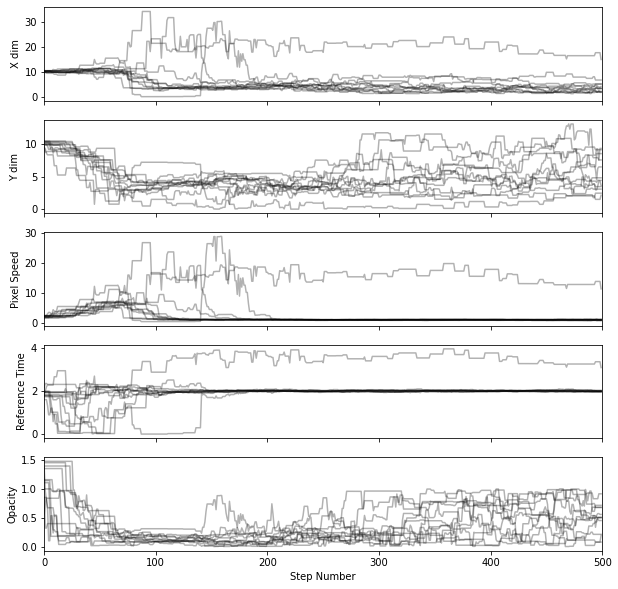

In [19]:
##This block plots the traces of the 4 parameters
fig, axes = plt.subplots(5,figsize = (10,10), sharex = True)
samples = sampler.get_chain()
labels = ["X dim", "Y dim", "Pixel Speed", "Reference Time", "Opacity"]
for i in range(ndim):
    axes[i].plot(samples[:,:,i],'k',alpha = 0.3)
    axes[i].set_xlim(0,len(samples))
    axes[i].set_ylabel(labels[i])
    
axes[-1].set_xlabel("Step Number")
plt.show()

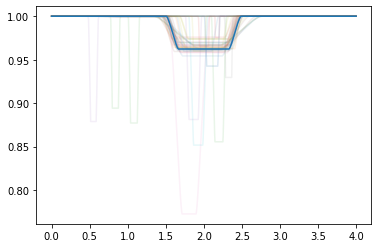

In [20]:
fig = plt.subplot()
flat_samples = sampler.get_chain(discard=10, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=50)
for ind in inds:
    sample = flat_samples[ind]
    sampleFlux = transitSim(sample[0],sample[1],20,sample[2],times,sample[3],1)
    fig.plot(times,sampleFlux,alpha = 0.1)
    
fig.plot(times,flux)
plt.show()
    